# Modeling

Here we will do the modeling of housing prices

In [1]:
import math
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from tensorboard.plugins.hparams import api as hp
import scikeras
from scikeras.wrappers import KerasRegressor
import skopt
from skopt import BayesSearchCV
import scipy
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy.optimize import minimize

%load_ext tensorboard

In [2]:
data = pd.read_csv("modelling_data.csv", parse_dates=['saleDate_b','valuationDate_b'])

In [3]:
data.shape

(29622, 60)

In [4]:
def PercentWithinAlpha(predictedVal, trueVal, alpha = 0.2):
    return np.mean(np.abs((predictedVal - trueVal) / trueVal) <= alpha)

def PercentWithinAlphaText(predictedVal, trueVal, alpha = 0.2):
    print(round(PercentWithinAlpha(predictedVal, trueVal, alpha) * 100, 2),
          '% of predictions within ', alpha * 100, '% of true value')
    

# Preprocessing 

In [5]:
X = data.drop(['salePrice_b', 'AVM_price_d', 'paymentCash_b', 'm2Price', 'street_b', 'streetName_b', 'address_b',
              'saleDate_b', 'salesYear_b', 'valuationDate_b', 'longitude_b', 'latitude_b'],
              axis = 1)
y = data['salePrice_b']

In [6]:
cat_var = list(X.select_dtypes(include=['object', 'category']))
num_var = list(X.select_dtypes(include=['float64', 'int64']))


In [7]:
for cat in cat_var:
    X[cat] = X[cat].astype('category')

In [8]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(X, X[["itemTypeName_b"]]):
    X_train = X.loc[train_index]
    X_test = X.loc[test_index]
    y_train = np.array(y.loc[train_index])
    y_test = np.array(y.loc[test_index])
    
X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)


for train_index, test_index in split.split(X_train, X_train[["itemTypeName_b"]]):
    X_train2 = X_train.loc[train_index]
    X_val = X_train.loc[test_index]
    y_train2 = np.array(y_train[train_index])
    y_val = np.array(y_train[test_index])

X_train2.reset_index(drop = True, inplace = True)
X_val.reset_index(drop = True, inplace = True)

#print(X["itemTypeName_b"].value_counts(normalize = True).to_latex(index = True))
#print(X_train["itemTypeName_b"].value_counts(normalize = True).to_latex(index = True))

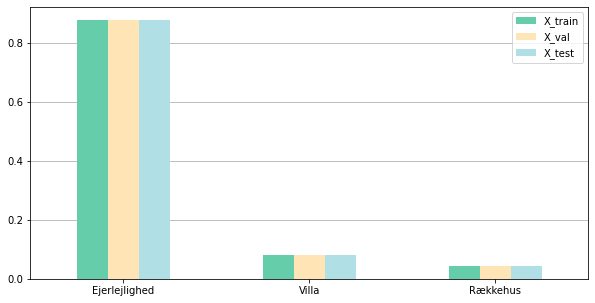

In [9]:
pltdata = pd.DataFrame()
pltdata['X_train'] = X_train2["itemTypeName_b"].value_counts(normalize = True)
pltdata['X_val'] = X_val["itemTypeName_b"].value_counts(normalize = True)
pltdata['X_test'] = X_test["itemTypeName_b"].value_counts(normalize = True)

pltdata.plot.bar(rot=0, color={"X_train": "mediumaquamarine", "X_val": "moccasin", 'X_test': 'powderblue'}, zorder = 2, figsize = (10,5))
plt.grid(visible = True, axis = 'y', zorder = 0)
plt.savefig('/Users/Mikkel/Desktop/stratsample.png', bbox_inches = "tight", dpi = 300)

In [10]:
X_train_onehot = pd.get_dummies(X_train, columns=cat_var, drop_first=True)
X_train2_onehot = pd.get_dummies(X_train2, columns=cat_var, drop_first=True)
X_val_onehot = pd.get_dummies(X_val, columns=cat_var, drop_first=True)
X_test_onehot = pd.get_dummies(X_test, columns=cat_var, drop_first=True)

In [11]:
print(X_train.shape)
print('n train:', len(X_train2))
print('n val:', len(X_val))
print('n test:', len(X_test))

print('n train + val:', len(X_train))

(23697, 48)
n train: 18957
n val: 4740
n test: 5925
n train + val: 23697


In [12]:
X_train2_onehot.shape

(18957, 86)

### One-hot encoding and standardizer

In [13]:
pipe = Pipeline([("scaler", StandardScaler()),
])

pipe.fit(X_train2_onehot)


print() # don't wan't to see the output of pipe.fit

In [14]:
print(X_train2.shape)
print(X_val.shape)
print(X_test.shape)

(18957, 48)
(4740, 48)
(5925, 48)


In [15]:
X_train_scaled= pipe.transform(X_train_onehot )
X_train2_scaled = pipe.transform(X_train2_onehot)
X_val_scaled = pipe.transform(X_val_onehot)
X_test_scaled = pipe.transform(X_test_onehot)


In [16]:
print(X_train_scaled.shape)
print(X_train_onehot.shape)

(23697, 86)
(23697, 86)


In [17]:
logY_train = np.log(y_train)
logY_train2 = np.log(y_train2)
logY_val = np.log(y_val)
logY_test = np.log(y_test)

# Baseline models

### Auxilirary functions

In [18]:
def plotConvergence(history, dropLR = False, **kwargs):
    hist = pd.DataFrame(history)
    hist.rename(columns = {'loss':'training', 'val_loss':'validation'}, inplace = True)
    if dropLR == True:
        hist.drop(['lr'], axis = 1, inplace = True)
    
    hist.plot(**kwargs)
    
    plt.xlabel('epoch')
    plt.ylabel('loss')
    

### Linear model

In [19]:
linReg = LinearRegression()
linReg.fit(X_train2_scaled, y_train2)

y_train_pred = linReg.predict(X_train2_scaled)
y_test_pred = linReg.predict(X_val_scaled)

PercentWithinAlphaText(y_test_pred, y_val, alpha = 0.20)
PercentWithinAlphaText(y_test_pred, y_val, alpha = 0.15)
PercentWithinAlphaText(y_test_pred, y_val, alpha = 0.10)

print('R2: ', linReg.score(X_test_scaled, y_test))

77.55 % of predictions within  20.0 % of true value
66.24 % of predictions within  15.0 % of true value
49.26 % of predictions within  10.0 % of true value
R2:  0.8118821753579522


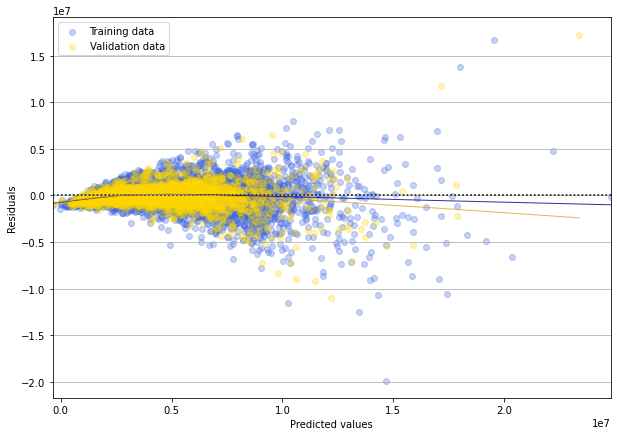

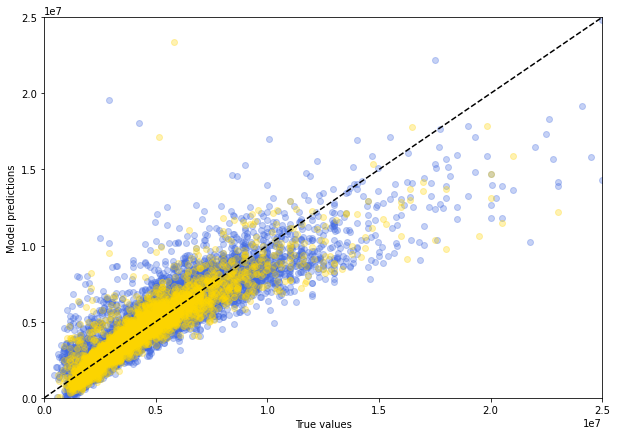

In [32]:
plt.figure(figsize = (10, 7))

sns.residplot(x=y_train_pred, y=y_train_pred - y_train2, lowess=True, color = 'royalblue', 
                              scatter_kws={'alpha': 0.3},
                              line_kws={'color': 'darkblue', 'lw': 1, 'alpha': 0.8}, label='Training data')
sns.residplot(x=y_test_pred, y=y_test_pred - y_val, color = 'gold', 
                              scatter_kws={'alpha': 0.3}, lowess=True,
                              line_kws={'color': 'goldenrod', 'lw': 1, 'alpha': 0.8}, label='Validation data')

plt.grid(visible = True, axis = 'y', zorder = 0)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')

plt.savefig('/Users/Mikkel/Desktop/linearRes1.png', bbox_inches = "tight", dpi = 300)
plt.show()

plt.figure(figsize=(10,7))
plt.scatter(y_train2, y_train_pred, alpha=0.3, c = 'royalblue')
plt.scatter(y_val, y_test_pred, alpha=0.3, c = 'gold')
plt.plot([0, 2.5e7], [0, 2.5e7], ls="--", c="black")
plt.ylabel('Model predictions')
plt.xlabel('True values')
plt.xlim([0, 25000000])
plt.ylim([0, 25000000])

plt.savefig('/Users/Mikkel/Desktop/linearFit1.png', bbox_inches = "tight", dpi = 300)

plt.show()

In [27]:
logLinReg = LinearRegression()
logLinReg.fit(X_train2_scaled, logY_train2)

logY_train_pred = logLinReg.predict(X_train2_scaled)
logY_test_pred = logLinReg.predict(X_val_scaled)

In [28]:
y_test_exp_pred = np.exp(logY_test_pred)

PercentWithinAlphaText(y_test_exp_pred, y_val, alpha = 0.20)
PercentWithinAlphaText(y_test_exp_pred, y_val, alpha = 0.15)
PercentWithinAlphaText(y_test_exp_pred, y_val, alpha = 0.10)
#PercentWithinAlphaText(y_test_exp_pred, y_test, alpha = 0.14839)
print('R2: ', logLinReg.score(X_test_scaled, np.log(y_test)))

81.46 % of predictions within  20.0 % of true value
68.69 % of predictions within  15.0 % of true value
50.21 % of predictions within  10.0 % of true value
R2:  0.8499292730937642


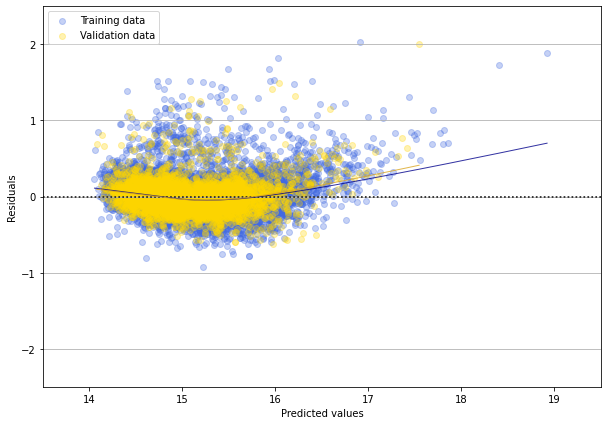

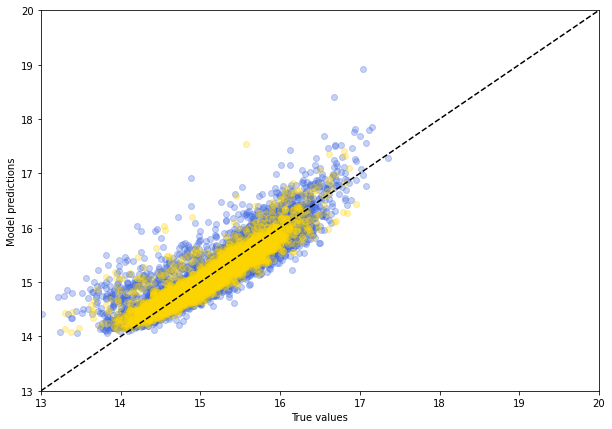

In [33]:
plt.figure(figsize = (10, 7))

sns.residplot(x=logY_train_pred, y=logY_train_pred - logY_train2, lowess=True, color = 'royalblue', 
                              scatter_kws={'alpha': 0.3}, 
                              line_kws={'color': 'darkblue', 'lw': 1, 'alpha': 0.8}, label='Training data')
sns.residplot(x=logY_test_pred, y=logY_test_pred - logY_val, color = 'gold', 
                              scatter_kws={'alpha': 0.3}, lowess=True,
                              line_kws={'color': 'goldenrod', 'lw': 1, 'alpha': 0.8}, label='Validation data')

plt.grid(visible = True, axis = 'y', zorder = 0)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.xlim([13.5, 19.5])
plt.ylim([-2.5, 2.5])
plt.savefig('/Users/Mikkel/Desktop/linearRes2.png', bbox_inches = "tight", dpi = 300)

plt.figure(figsize = (10, 7))
plt.scatter(logY_train2, logY_train_pred, alpha=0.3, c = 'royalblue')
plt.scatter(logY_val, logY_test_pred, alpha=0.3, c = 'gold')
plt.plot([13, 20], [13, 20], ls="--", c="black")
plt.ylabel('Model predictions')
plt.xlabel('True values')
plt.xlim([13, 20])
plt.ylim([13, 20])

plt.savefig('/Users/Mikkel/Desktop/linearFit2.png', bbox_inches = "tight", dpi = 300)

plt.show()

In [251]:
mean_absolute_error(logY_val, logLinReg.predict(X_val_scaled)), 
                       mean_absolute_percentage_error(y_val, np.exp(logLinReg.predict(X_val_scaled)))


{'OLS': (0.13401266930177674, 0.14332039653786893)}

In [187]:
logLinReg.score(X_val_scaled, logY_val)

0.8536823797484698

86

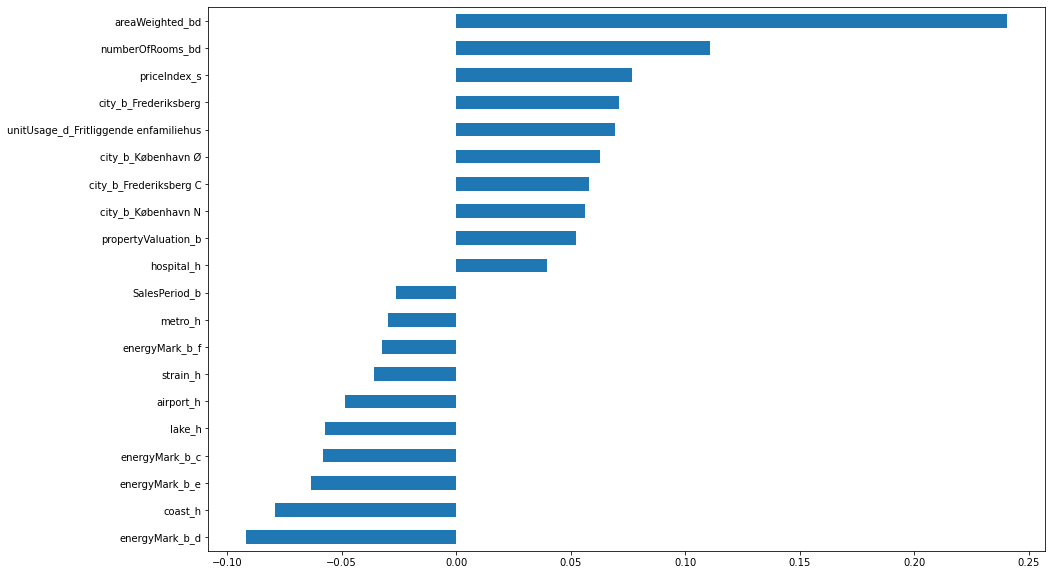

In [34]:
feature_names = np.array(X_train_onehot.columns)
coefs = pd.DataFrame(
    logLinReg.coef_ ,
    columns=['Coefficients'], index=feature_names
)

imp_coef = pd.concat([coefs.sort_values(by=['Coefficients']).head(10),
                     coefs.sort_values(by=['Coefficients']).tail(10)])

plt.rcParams['figure.figsize'] = (15.0, 10.0)
imp_coef.plot(kind = "barh", legend=None)

plt.savefig('/Users/Mikkel/Desktop/linearCoef.png', bbox_inches = "tight", dpi = 300)

### Random Forrest

In [61]:
ns = [5,10,15,25,30,35,40,45,50, 60, 70, 80, 90, 100]
scores = list()
for n in ns:
    print(f'n={n}')
    rfn = RandomForestRegressor(n_estimators = n, criterion = 'absolute_error', random_state = 2)
    score = cross_val_score(rfn, X_train2_scaled, logY_train2, cv = 5, scoring = 'neg_mean_absolute_error')
    scores.append(score)

n=5


NameError: name 'rfX_train' is not defined

In [642]:
maes = -np.vstack(scores)
means = np.mean(maes, axis = 1)

print(len(ns))
print(len(maes))
print(len(means))

14
14
14


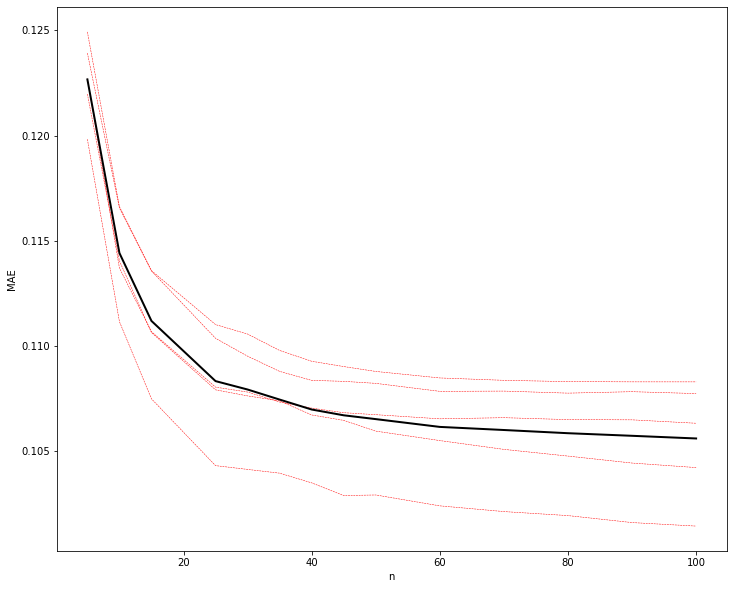

In [644]:
fig, ax = plt.subplots(figsize = (12,10))


for i in range(5):
    ax.plot(ns, maes[:,i], '--', linewidth=0.5, c='red')

ax.plot(ns, means, linewidth=2, c='black')    

plt.xlabel('n')
plt.ylabel('MAE')

plt.savefig('/Users/Mikkel/Desktop/rfTuning.png')

plt.show()

In [275]:
%%time
rf = RandomForestRegressor(n_estimators = 40, criterion = 'absolute_error', random_state = 2)
rf.fit(X_train2_scaled, logY_train2)

CPU times: user 26min 26s, sys: 8.43 s, total: 26min 35s
Wall time: 27min 12s


RandomForestRegressor(criterion='absolute_error', n_estimators=40,
                      random_state=2)

In [276]:
(mean_absolute_error(logY_val, rf.predict(X_val_scaled)), 
 mean_absolute_percentage_error(y_val, np.exp(rf.predict(X_val_scaled))))


(0.10485164720372449, 0.11230522529889135)

In [277]:
PercentWithinAlphaText(np.exp(rf.predict(X_val_scaled)), y_val, alpha = 0.20)
PercentWithinAlphaText(np.exp(rf.predict(X_val_scaled)), y_val, alpha = 0.15)
PercentWithinAlphaText(np.exp(rf.predict(X_val_scaled)), y_val, alpha = 0.10)

88.88 % of predictions within  20.0 % of true value
80.8 % of predictions within  15.0 % of true value
64.79 % of predictions within  10.0 % of true value


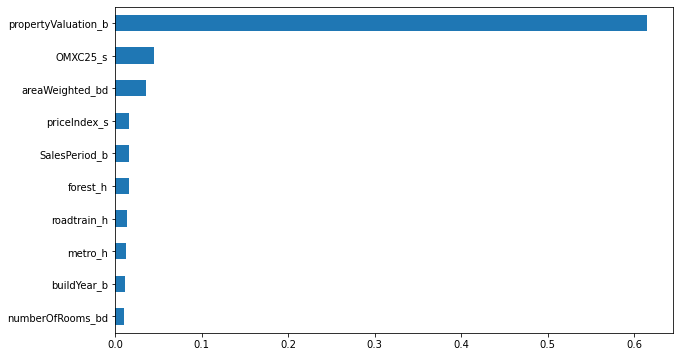

In [279]:
feature_names2 = np.array(X_train_onehot.columns)
coefs = pd.DataFrame(
    rf.feature_importances_,
    columns=['Coefficients'], index=feature_names2
)

imp_coef = coefs.sort_values(by=['Coefficients'], ascending = True).tail(10)
imp_coef.plot(kind = "barh", legend=None, figsize = (10,6))

plt.savefig('/Users/Mikkel/Desktop/randomforestCoef.png', bbox_inches = "tight")

# Neural networks

## Simple deep NN's

In [35]:
es_cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=25, verbose=0,restore_best_weights=True)
LR_scheduler = keras.callbacks.ReduceLROnPlateau(factor = 0.2, patience = 10, verbose = 0, min_lr = 0.00001)

In [36]:
def buildDnn(n_hiddenLayers = 1, n_neurons = 30, 
               activ = 'relu', init = "he_normal", lossFunc = 'mean_absolute_error', 
               learning_rate = 0.05, normalize_all_layers = False):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape = X_train_scaled.shape[1])) # adding the input layer.
    #model.add(keras.layers.BatchNormalization())
    
    #adding the hidden layers.
    for i in range(n_hiddenLayers):
        if (normalize_all_layers & (i < n_hiddenLayers)):
            model.add(keras.layers.Dense(n_neurons, kernel_initializer=init))
            model.add(keras.layers.BatchNormalization())
            model.add(keras.layers.Activation(activ))
        else:
            model.add(keras.layers.Dense(n_neurons, activation = activ, kernel_initializer=init))
       
        
        
    #adding output layer.
    model.add(keras.layers.Dense(1))
    
    #renaming layers
    #i = 1
    #for layer in model.layers:
    #    layer._name = 'dense_'+ str(i)
    #    i += 1
    
    #compiling the model with the specified loss function and learning rate.
    model.compile(loss= lossFunc, optimizer=tf.keras.optimizers.Adam(learning_rate))
    
    return model


In [66]:
dnn1 = buildDnn(3, 50, learning_rate = 0.01)
dnn1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 50)                4350      
                                                                 
 dense_22 (Dense)            (None, 50)                2550      
                                                                 
 dense_23 (Dense)            (None, 50)                2550      
                                                                 
 dense_24 (Dense)            (None, 1)                 51        
                                                                 
Total params: 9,501
Trainable params: 9,501
Non-trainable params: 0
_________________________________________________________________


In [67]:
history4 = dnn1.fit(X_train2_scaled, logY_train2,
            validation_data=(X_val_scaled, logY_val),
            verbose=1, 
            epochs=400,
            callbacks = [LR_scheduler, es_cb]
            )


Epoch 1/400
593/593 [==============================] - 2s 3ms/step - loss: 1.0006 - val_loss: 0.7666 - lr: 0.0100
Epoch 2/400
593/593 [==============================] - 2s 3ms/step - loss: 0.4851 - val_loss: 0.3278 - lr: 0.0100
Epoch 3/400
593/593 [==============================] - 2s 3ms/step - loss: 0.3220 - val_loss: 0.3260 - lr: 0.0100
Epoch 4/400
593/593 [==============================] - 1s 2ms/step - loss: 0.2100 - val_loss: 0.1740 - lr: 0.0100
Epoch 5/400
593/593 [==============================] - 2s 3ms/step - loss: 0.1441 - val_loss: 0.1338 - lr: 0.0100
Epoch 6/400
593/593 [==============================] - 1s 2ms/step - loss: 0.1244 - val_loss: 0.1222 - lr: 0.0100
Epoch 7/400
593/593 [==============================] - 1s 2ms/step - loss: 0.1210 - val_loss: 0.1340 - lr: 0.0100
Epoch 8/400
593/593 [==============================] - 1s 2ms/step - loss: 0.1240 - val_loss: 0.1123 - lr: 0.0100
Epoch 9/400
593/593 [==============================] - 1s 2ms/step - loss: 0.1197 - val_

593/593 [==============================] - 1s 2ms/step - loss: 0.0822 - val_loss: 0.0978 - lr: 4.0000e-04
Epoch 73/400
593/593 [==============================] - 1s 2ms/step - loss: 0.0825 - val_loss: 0.0980 - lr: 4.0000e-04
Epoch 74/400
593/593 [==============================] - 1s 2ms/step - loss: 0.0822 - val_loss: 0.0986 - lr: 4.0000e-04
Epoch 75/400
593/593 [==============================] - 1s 2ms/step - loss: 0.0821 - val_loss: 0.0979 - lr: 4.0000e-04
Epoch 76/400
593/593 [==============================] - 1s 2ms/step - loss: 0.0822 - val_loss: 0.0981 - lr: 4.0000e-04
Epoch 77/400
593/593 [==============================] - 1s 2ms/step - loss: 0.0819 - val_loss: 0.0983 - lr: 4.0000e-04
Epoch 78/400
593/593 [==============================] - 1s 2ms/step - loss: 0.0819 - val_loss: 0.0979 - lr: 4.0000e-04
Epoch 79/400
593/593 [==============================] - 1s 2ms/step - loss: 0.0819 - val_loss: 0.0983 - lr: 4.0000e-04
Epoch 80/400
593/593 [==============================] - 1s 2m

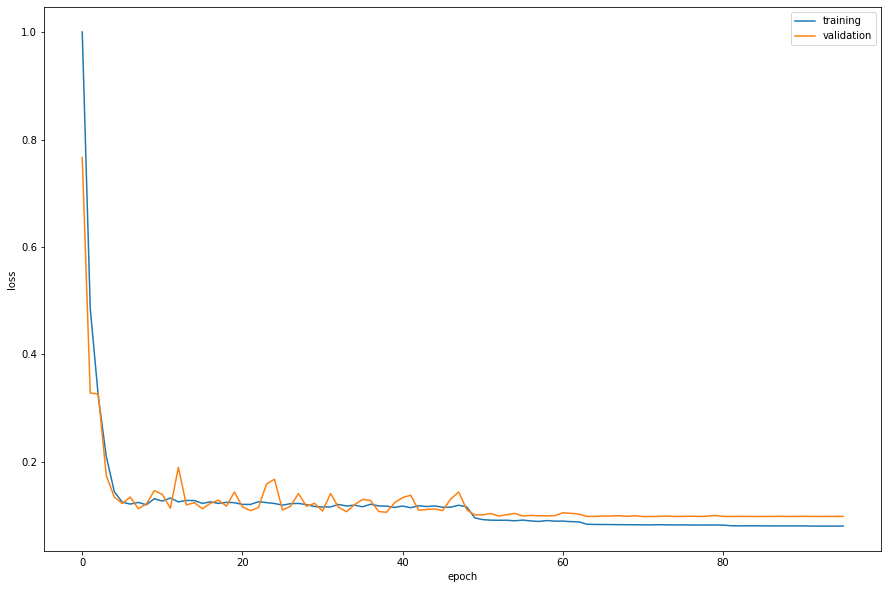

In [68]:
plotConvergence(history4.history, dropLR = True)
#plt.ylim([0.05,0.69])
plt.savefig('/Users/Mikkel/Desktop/dnnConvergence1.png', bbox_inches = "tight", dpi = 300)

In [69]:
logY_train_dnn_pred = dnn1.predict(X_train2_scaled).reshape(-1)
logY_test_dnn_pred = dnn1.predict(X_val_scaled).reshape(-1)

y_train_dnn_pred = np.exp(logY_train_dnn_pred)
y_test_dnn_pred = np.exp(logY_test_dnn_pred)


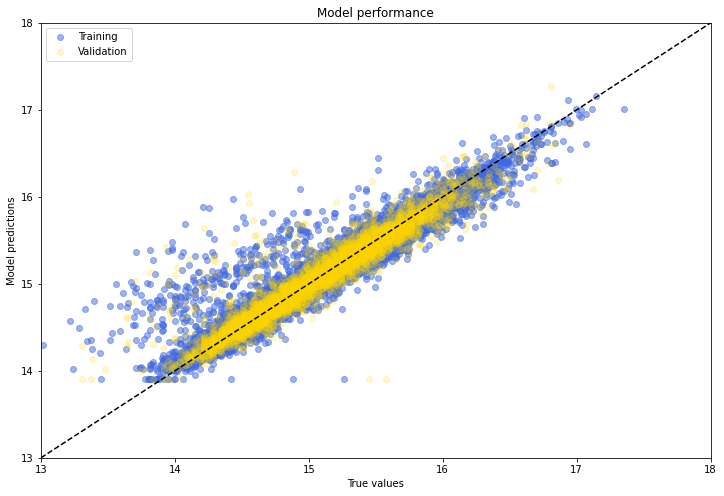

In [70]:
plt.figure(figsize = (12, 8))

plt.scatter(logY_train2, logY_train_dnn_pred, alpha=0.5, c = 'royalblue', label = 'Training')
plt.scatter(logY_val, logY_test_dnn_pred, alpha=0.2, c = 'gold', label = 'Validation')
plt.legend(loc='upper left')
plt.plot([13, 18], [13, 18], ls="--", c="black")
plt.ylabel('Model predictions')
plt.xlabel('True values')
plt.xlim([13, 18])
plt.ylim([13, 18])

plt.title('Model performance')

plt.savefig('/Users/Mikkel/Desktop/dnnPredict1.png', bbox_inches = "tight", dpi = 300)

plt.show()

In [570]:
PercentWithinAlphaText(y_test_dnn_pred, y_val, 0.2)
PercentWithinAlphaText(y_test_dnn_pred, y_val, 0.15)
PercentWithinAlphaText(y_test_dnn_pred, y_val, 0.1)
print('MAE', mean_absolute_error(logY_val, logY_test_dnn_pred))
print('MAPE', mean_absolute_percentage_error(y_val, y_test_dnn_pred))

91.39 % of predictions within  20.0 % of true value
84.24 % of predictions within  15.0 % of true value
68.23 % of predictions within  10.0 % of true value
MAE 0.09571114100886705
MAPE 0.10563968049884373


### Regularisation - Dropout

In [66]:
def buildRegDnn(n_hiddenLayers = 1, n_neurons = 30, DORate = 0.2,
               activ = 'relu', init = "he_normal", lossFunc = 'mean_absolute_error', 
               learning_rate = 0.05, normalize_all_layers = False):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape = X_train_scaled.shape[1])) # adding the input layer.
    #model.add(keras.layers.BatchNormalization())
    
    #adding the hidden layers.
    for i in range(n_hiddenLayers):
        if (normalize_all_layers & (i < n_hiddenLayers)):
            model.add(keras.layers.Dropout(rate = DORate))
            model.add(keras.layers.Dense(n_neurons, kernel_initializer=init))
            model.add(keras.layers.BatchNormalization())
            model.add(keras.layers.Activation(activ))
        else:
            model.add(keras.layers.Dropout(rate = DORate))
            model.add(keras.layers.Dense(n_neurons, activation = activ, kernel_initializer=init))
        
    #adding output layer.
    model.add(keras.layers.Dense(1))
    
    #compiling the model with the specified loss function and learning rate.
    model.compile(loss= lossFunc, optimizer=tf.keras.optimizers.Adam(learning_rate))
    
    return model


In [254]:
regDnn1 = buildRegDnn(3, 50, DORate = 0.1, learning_rate = 0.01, normalize_all_layers = False)
regDnn1.summary()

Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 86)                0         
                                                                 
 dense_550 (Dense)           (None, 50)                4350      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_551 (Dense)           (None, 50)                2550      
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_552 (Dense)           (None, 50)                2550      
                                                                 
 dense_553 (Dense)           (None, 1)               

In [597]:
regHist = regDnn1.fit(X_train2_scaled, logY_train2,
            validation_data=(X_val_scaled, logY_val),
            verbose=0, 
            epochs=400,
            callbacks = [LR_scheduler, es_cb])

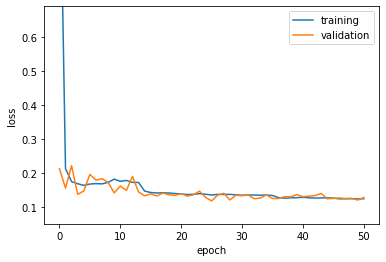

In [598]:
plotConvergence(regHist.history, dropLR = True)
plt.ylim([0.05,0.69])
plt.savefig('/Users/Mikkel/Desktop/dnnConvergence2.png')

In [599]:
pred_val = regDnn1.predict(X_val_scaled).reshape(-1)
PercentWithinAlphaText(np.exp(pred_val), y_val, 0.2)
PercentWithinAlphaText(np.exp(pred_val), y_val, 0.15)
PercentWithinAlphaText(np.exp(pred_val), y_val, 0.1)
print('MAE: ', mean_absolute_error(logY_val, pred_val))
print('MAPE: ', mean_absolute_percentage_error(y_val, np.exp(pred_val)))

85.4 % of predictions within  20.0 % of true value
73.92 % of predictions within  15.0 % of true value
56.33 % of predictions within  10.0 % of true value
MAE:  0.11736111322123957
MAPE:  0.127806840159867


### bad predictions

In [258]:
x = np.hstack([logY_train2, logY_val])
z = np.hstack([logY_train_dnn_pred, logY_test_dnn_pred])

res = z - x

print('min: ', np.min(res))
print('max: ', np.max(res))
print('mean: ', np.mean(res))
print('median: ', np.median(res))

min:  -0.5498618683683603
max:  1.7960853707338202
mean:  0.006997011138955175
median:  -0.005357097678684752


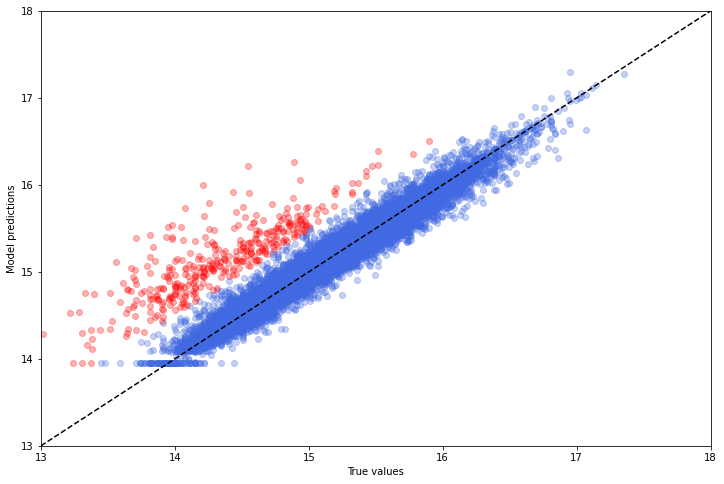

In [264]:
index = res > 0.5

plt.figure(figsize = (12, 8))

plt.scatter(x[~index], z[~index], alpha=0.3, c = 'royalblue', label = 'Good predictions')
plt.scatter(x[index], z[index], alpha=0.3, c = 'red', label = 'Bad predictions')
plt.plot([13, 18], [13, 18], ls="--", c="black")
plt.ylabel('Model predictions')
plt.xlabel('True values')
plt.xlim([13, 18])
plt.ylim([13, 18])

plt.savefig('/Users/Mikkel/Desktop/badpredictions.png')

In [265]:
sum(index)

361

In [585]:
Q = pd.concat([X_train2, X_val])
x_res = Q.iloc[index, :]

numerics = x_res.select_dtypes(include=['float64', 'int64'])

numerics.drop(columns = ['salesYear_b']).describe().T[['mean', 'min', 'max']] \
- Q.iloc[~index, :].select_dtypes(include=['float64', 'int64']).drop(columns = ['salesYear_b']).describe().T[['mean', 'min', 'max']]


,mean,min,max
propertyValuation_b,129833.390683,0.00,-36900000.00
buildYear_b,-6.457321,134.00,-2.00
areaParcel_b,3.693611,0.00,1.00
numberOfFloors_b,0.239155,0.00,-7.00
floor_b,0.037786,1.00,-2.00
SalesPeriod_b,12.610978,0.00,-10.00
numberOfToilets_b,-0.015769,1.00,-1.00
numberOfBathrooms_b,-0.021036,0.00,-2.00
breakinRisk_b,0.000000,0.00,0.00
rebuildYear_bd,-4.747019,153.00,-2.00


In [586]:
print('mean')
print(x_res['propertyValuation_b'].mean())
print(Q.loc[~index, 'propertyValuation_b'].mean())
print()
print('median')
print(x_res['propertyValuation_b'].median())
print(Q.loc[~index, 'propertyValuation_b'].median())

mean
2046901.4084507043
1917068.0177679067

median
1800000.0
1650000.0


(13.0, 18.0)

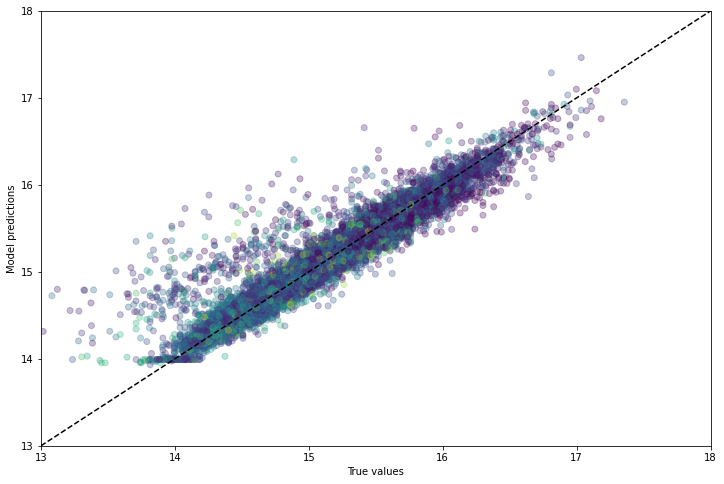

In [566]:
plt.figure(figsize = (12, 8))

plt.scatter(x, z, alpha=0.3, c = Q['coast_h'])
plt.plot([13, 18], [13, 18], ls="--", c="black")
plt.ylabel('Model predictions')
plt.xlabel('True values')
plt.xlim([13, 18])
plt.ylim([13, 18])


### Tuning hyperparameters

In [649]:
hp_n_neurons = hp.HParam('n_neurons', hp.Discrete([50,60,70,80]))
hp_n_hiddenLayers = hp.HParam('n_hiddenLayers', hp.Discrete([2,4,6,8,10]))
hp_activation = hp.HParam('activ', hp.Discrete(['relu', 'elu']))
hp_normalize = hp.HParam('normalize_all_layers', hp.Discrete([False, True]))
hp_DropRate = hp.HParam('DORate', hp.RealInterval(0., 0.1))

hp_metric = 'mean_absolute_error'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
    hparams=[hp_n_neurons, hp_n_hiddenLayers, hp_DropRate, hp_activation, hp_normalize],
    metrics=[hp.Metric(hp_metric, display_name='MAE')],
  )

In [659]:
def train_test_model(hparams):
    lr = 0.005
    if hparams[hp_DropRate] > 0. :
        lr = 0.1
    
    model = buildRegDnn(hparams[hp_n_hiddenLayers], hparams[hp_n_neurons], DORate = hparams[hp_DropRate],
                     activ = hparams[hp_activation], normalize_all_layers = hparams[hp_normalize],
                     learning_rate = lr)
    
    X_temp, X_val, y_temp, y_val = train_test_split(X_train2_scaled, logY_train2, test_size = 0.2)
    
    model.fit(X_temp, y_temp,
            validation_split=0.1,
            verbose=0, 
            epochs=400,
            callbacks = [LR_scheduler, es_cb]# cp_cb('area_model2')]
            )
    
    return model.evaluate(x = X_val, y = y_val, verbose = 0)

def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        MAE = train_test_model(hparams)
        tf.summary.scalar(hp_metric, MAE, step=1)
        
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

In [660]:
n_combo = len(hp_n_neurons.domain.values) * len(hp_n_hiddenLayers.domain.values) * \
            len(hp_activation.domain.values) * len(hp_normalize.domain.values) * 2
session_num = 1

for num_units in hp_n_neurons.domain.values:
    for num_hidden in hp_n_hiddenLayers.domain.values:
        for dropRate in list(np.linspace(hp_DropRate.domain.min_value, hp_DropRate.domain.max_value, 2)):
            for activation in hp_activation.domain.values:
                for normalize in hp_normalize.domain.values:
                    hparams = {
                                hp_n_neurons: num_units,
                                hp_n_hiddenLayers: num_hidden,
                                hp_DropRate: dropRate,
                                hp_activation: activation,
                                hp_normalize: normalize,
                               }
                    run_name = "run-{}".format(session_num)
                    print('--- Starting trial: {}/{}'.format(run_name, n_combo))
                    print({h.name: hparams[h] for h in hparams})
                    run('logs/hparam_tuning/' + run_name, hparams) # comment out to avoid running the very slow grid search
                    print('{}% done'.format(round(session_num/n_combo * 100, 2)))
                    session_num += 1


--- Starting trial: run-1/160
{'n_neurons': 50, 'n_hiddenLayers': 2, 'DORate': 0.0, 'activ': 'elu', 'normalize_all_layers': False}
0.62% done
--- Starting trial: run-2/160
{'n_neurons': 50, 'n_hiddenLayers': 2, 'DORate': 0.0, 'activ': 'elu', 'normalize_all_layers': True}
1.25% done
--- Starting trial: run-3/160
{'n_neurons': 50, 'n_hiddenLayers': 2, 'DORate': 0.0, 'activ': 'relu', 'normalize_all_layers': False}
1.88% done
--- Starting trial: run-4/160
{'n_neurons': 50, 'n_hiddenLayers': 2, 'DORate': 0.0, 'activ': 'relu', 'normalize_all_layers': True}
2.5% done
--- Starting trial: run-5/160
{'n_neurons': 50, 'n_hiddenLayers': 2, 'DORate': 0.1, 'activ': 'elu', 'normalize_all_layers': False}
3.12% done
--- Starting trial: run-6/160
{'n_neurons': 50, 'n_hiddenLayers': 2, 'DORate': 0.1, 'activ': 'elu', 'normalize_all_layers': True}
3.75% done
--- Starting trial: run-7/160
{'n_neurons': 50, 'n_hiddenLayers': 2, 'DORate': 0.1, 'activ': 'relu', 'normalize_all_layers': False}
4.38% done
--- Sta

36.25% done
--- Starting trial: run-59/160
{'n_neurons': 60, 'n_hiddenLayers': 6, 'DORate': 0.0, 'activ': 'relu', 'normalize_all_layers': False}
36.88% done
--- Starting trial: run-60/160
{'n_neurons': 60, 'n_hiddenLayers': 6, 'DORate': 0.0, 'activ': 'relu', 'normalize_all_layers': True}
37.5% done
--- Starting trial: run-61/160
{'n_neurons': 60, 'n_hiddenLayers': 6, 'DORate': 0.1, 'activ': 'elu', 'normalize_all_layers': False}
38.12% done
--- Starting trial: run-62/160
{'n_neurons': 60, 'n_hiddenLayers': 6, 'DORate': 0.1, 'activ': 'elu', 'normalize_all_layers': True}
38.75% done
--- Starting trial: run-63/160
{'n_neurons': 60, 'n_hiddenLayers': 6, 'DORate': 0.1, 'activ': 'relu', 'normalize_all_layers': False}
39.38% done
--- Starting trial: run-64/160
{'n_neurons': 60, 'n_hiddenLayers': 6, 'DORate': 0.1, 'activ': 'relu', 'normalize_all_layers': True}
40.0% done
--- Starting trial: run-65/160
{'n_neurons': 60, 'n_hiddenLayers': 8, 'DORate': 0.0, 'activ': 'elu', 'normalize_all_layers': 

71.88% done
--- Starting trial: run-116/160
{'n_neurons': 70, 'n_hiddenLayers': 10, 'DORate': 0.0, 'activ': 'relu', 'normalize_all_layers': True}
72.5% done
--- Starting trial: run-117/160
{'n_neurons': 70, 'n_hiddenLayers': 10, 'DORate': 0.1, 'activ': 'elu', 'normalize_all_layers': False}
73.12% done
--- Starting trial: run-118/160
{'n_neurons': 70, 'n_hiddenLayers': 10, 'DORate': 0.1, 'activ': 'elu', 'normalize_all_layers': True}
73.75% done
--- Starting trial: run-119/160
{'n_neurons': 70, 'n_hiddenLayers': 10, 'DORate': 0.1, 'activ': 'relu', 'normalize_all_layers': False}
74.38% done
--- Starting trial: run-120/160
{'n_neurons': 70, 'n_hiddenLayers': 10, 'DORate': 0.1, 'activ': 'relu', 'normalize_all_layers': True}
75.0% done
--- Starting trial: run-121/160
{'n_neurons': 80, 'n_hiddenLayers': 2, 'DORate': 0.0, 'activ': 'elu', 'normalize_all_layers': False}
75.62% done
--- Starting trial: run-122/160
{'n_neurons': 80, 'n_hiddenLayers': 2, 'DORate': 0.0, 'activ': 'elu', 'normalize_al

In [669]:
%reload_ext tensorboard
%tensorboard --logdir  logs/hparam_tuning

In [59]:
modF = buildDnn(8,50, activ = 'elu', normalize_all_layers = False, learning_rate = 0.005)

In [60]:
modF.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 50)                4350      
                                                                 
 dense_13 (Dense)            (None, 50)                2550      
                                                                 
 dense_14 (Dense)            (None, 50)                2550      
                                                                 
 dense_15 (Dense)            (None, 50)                2550      
                                                                 
 dense_16 (Dense)            (None, 50)                2550      
                                                                 
 dense_17 (Dense)            (None, 50)                2550      
                                                                 
 dense_18 (Dense)            (None, 50)               

In [61]:
modFHist = modF.fit(X_train2_scaled, logY_train2,
            validation_data=(X_val_scaled, logY_val),
            verbose=1, 
            epochs=400,
            callbacks = [LR_scheduler, es_cb])

Epoch 1/400
593/593 [==============================] - 3s 4ms/step - loss: 0.3660 - val_loss: 0.1366 - lr: 0.0050
Epoch 2/400
593/593 [==============================] - 2s 4ms/step - loss: 0.1545 - val_loss: 0.1340 - lr: 0.0050
Epoch 3/400
593/593 [==============================] - 2s 3ms/step - loss: 0.1430 - val_loss: 0.1112 - lr: 0.0050
Epoch 4/400
593/593 [==============================] - 2s 3ms/step - loss: 0.1423 - val_loss: 0.1194 - lr: 0.0050
Epoch 5/400
593/593 [==============================] - 2s 3ms/step - loss: 0.1299 - val_loss: 0.1155 - lr: 0.0050
Epoch 6/400
593/593 [==============================] - 2s 3ms/step - loss: 0.1314 - val_loss: 0.1185 - lr: 0.0050
Epoch 7/400
593/593 [==============================] - 2s 3ms/step - loss: 0.1248 - val_loss: 0.1185 - lr: 0.0050
Epoch 8/400
593/593 [==============================] - 2s 4ms/step - loss: 0.1212 - val_loss: 0.1115 - lr: 0.0050
Epoch 9/400
593/593 [==============================] - 2s 3ms/step - loss: 0.1239 - val_

593/593 [==============================] - 2s 3ms/step - loss: 0.0758 - val_loss: 0.0941 - lr: 4.0000e-05
Epoch 71/400
593/593 [==============================] - 2s 3ms/step - loss: 0.0757 - val_loss: 0.0937 - lr: 4.0000e-05
Epoch 72/400
593/593 [==============================] - 2s 3ms/step - loss: 0.0753 - val_loss: 0.0938 - lr: 1.0000e-05
Epoch 73/400
593/593 [==============================] - 2s 3ms/step - loss: 0.0752 - val_loss: 0.0939 - lr: 1.0000e-05
Epoch 74/400
593/593 [==============================] - 2s 4ms/step - loss: 0.0753 - val_loss: 0.0939 - lr: 1.0000e-05
Epoch 75/400
593/593 [==============================] - 2s 3ms/step - loss: 0.0752 - val_loss: 0.0938 - lr: 1.0000e-05
Epoch 76/400
593/593 [==============================] - 2s 3ms/step - loss: 0.0752 - val_loss: 0.0938 - lr: 1.0000e-05


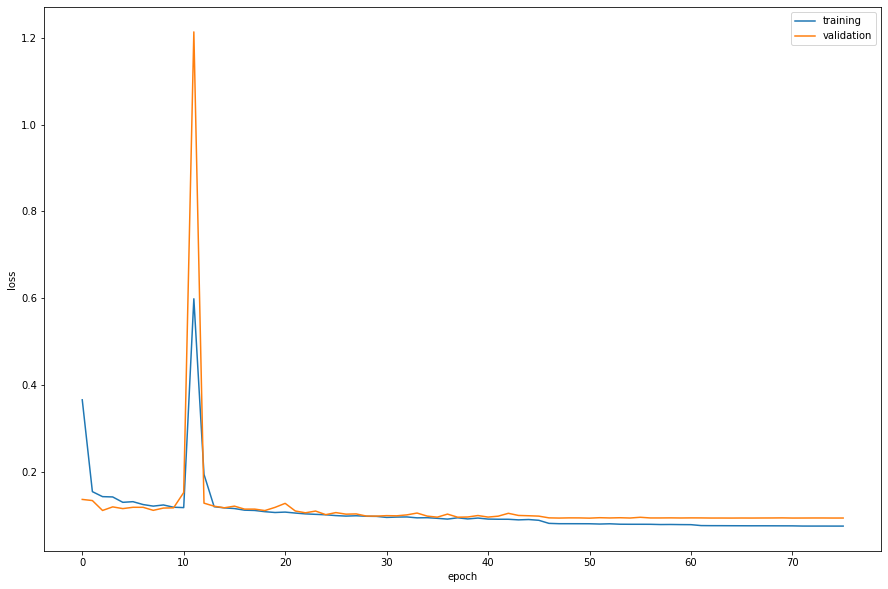

In [62]:
plotConvergence(modFHist.history, True)
#plt.ylim([0.05, 0.5])
plt.savefig('/Users/Mikkel/Desktop/dnnTunedConvergence.png', bbox_inches = "tight", dpi = 300)

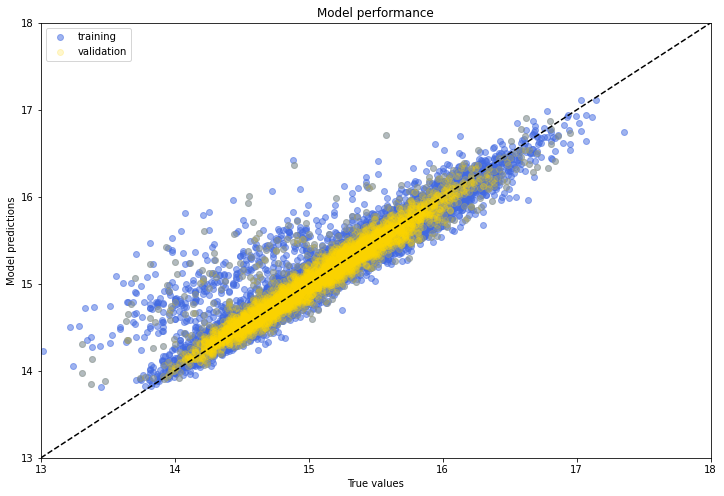

In [63]:
logY_train_dnn_tuned_pred = modF.predict(X_train_scaled).reshape(-1)
logY_test_dnn_tuned_pred = modF.predict(X_val_scaled).reshape(-1)

plt.figure(figsize = (12, 8))

plt.scatter(logY_train, logY_train_dnn_tuned_pred, alpha=0.5, c = 'royalblue', label = 'training')
plt.scatter(logY_val, logY_test_dnn_tuned_pred, alpha=0.2, c = 'gold', label = 'validation')
plt.legend(loc='upper left')
plt.plot([13, 18], [13, 18], ls="--", c="black")
plt.ylabel('Model predictions')
plt.xlabel('True values')
plt.xlim([13, 18])
plt.ylim([13, 18])

plt.title('Model performance')

plt.savefig('/Users/Mikkel/Desktop/dnnTunedPredict.png', bbox_inches = "tight", dpi = 300)

plt.show()

In [675]:
print('MAE: ',mean_absolute_error(logY_val, logY_test_dnn_tuned_pred))
print('MAPE: ', mean_absolute_percentage_error(y_val, np.exp(logY_test_dnn_tuned_pred)))

MAE:  0.09059113508014358
MAPE:  0.10034248194083102


In [676]:
PercentWithinAlphaText(np.exp(logY_test_dnn_tuned_pred), y_val, 0.2)
PercentWithinAlphaText(np.exp(logY_test_dnn_tuned_pred), y_val, 0.15)
PercentWithinAlphaText(np.exp(logY_test_dnn_tuned_pred), y_val, 0.1)

92.32 % of predictions within  20.0 % of true value
85.95 % of predictions within  15.0 % of true value
71.46 % of predictions within  10.0 % of true value


## Embedding of categorical variables

In [46]:
print(len(cat_var))
print(cat_var)

10
['city_b', 'itemTypeName_b', 'energyMark_b', 'unitUsage_d', 'outerwall_d', 'roof_d', 'radonRisk_d', 'noise_d', 'floodingRisk_d', 'biggestParty_d']


In [47]:
cat_list = []

cat_city = keras.layers.StringLookup(name = 'preprocess_for_city', num_oov_indices = 0)
cat_city.adapt(X_train['city_b'])
cat_list.append(cat_city)

cat_item = keras.layers.StringLookup(name = 'preprocess_for_item', num_oov_indices = 0)
cat_item.adapt(X_train['itemTypeName_b'])
cat_list.append(cat_item)

cat_em = keras.layers.StringLookup(name = 'preprocess_for_energyMark', num_oov_indices = 0)
cat_em.adapt(X_train['energyMark_b'])
cat_list.append(cat_em)

cat_unit = keras.layers.StringLookup(name = 'preprocess_for_unitUsage', num_oov_indices = 0)
cat_unit.adapt(X_train['unitUsage_d'])
cat_list.append(cat_unit)

cat_wall = keras.layers.StringLookup(name = 'preprocess_for_outerwall', num_oov_indices = 0)
cat_wall.adapt(X_train['outerwall_d'])
cat_list.append(cat_wall)

cat_roof = keras.layers.StringLookup(name = 'preprocess_for_roof', num_oov_indices = 0)
cat_roof.adapt(X_train['roof_d'])
cat_list.append(cat_roof)

cat_radon = keras.layers.StringLookup(name = 'preprocess_for_radonRisk', num_oov_indices = 0)
cat_radon.adapt(X_train['radonRisk_d'])
cat_list.append(cat_radon)

cat_noise = keras.layers.StringLookup(name = 'preprocess_for_noise', num_oov_indices = 0)
cat_noise.adapt(X_train['noise_d'])
cat_list.append(cat_noise)

cat_flood = keras.layers.StringLookup(name = 'preprocess_for_floodRisk', num_oov_indices = 0)
cat_flood.adapt(X_train['floodingRisk_d'])
cat_list.append(cat_flood)

cat_party = keras.layers.StringLookup(name = 'preprocess_for_party', num_oov_indices = 0)
cat_party.adapt(X_train['biggestParty_d'])
cat_list.append(cat_party)


In [48]:
len(cat_list)

10

In [49]:
def GetInputData(X):
    return (X['city_b'], X['itemTypeName_b'], X['energyMark_b'], X['unitUsage_d'], X['outerwall_d'], X['roof_d'],
            X['radonRisk_d'], X['noise_d'], X['floodingRisk_d'], X['biggestParty_d'], X[num_var])
    

In [50]:
print(len(cat_city.get_vocabulary()))
print(len(cat_item.get_vocabulary()))
print(len(cat_em.get_vocabulary()))
print(len(cat_unit.get_vocabulary()))
print(len(cat_wall.get_vocabulary()))
print(len(cat_roof.get_vocabulary()))
print(len(cat_radon.get_vocabulary()))
print(len(cat_noise.get_vocabulary()))
print(len(cat_flood.get_vocabulary()))
print(len(cat_party.get_vocabulary()))

14
3
12
5
3
5
4
5
3
4


In [51]:
#inputs
input_city = keras.layers.Input(shape=[1], dtype = tf.string, name="cat_city")
input_item = keras.layers.Input(shape=[1], dtype = tf.string, name="cat_item")
input_em = keras.layers.Input(shape=[1], dtype = tf.string, name="cat_energyMark")
input_unit = keras.layers.Input(shape=[1], dtype = tf.string, name="cat_unit")
input_wall = keras.layers.Input(shape=[1], dtype = tf.string, name="cat_wall")
input_roof = keras.layers.Input(shape=[1], dtype = tf.string, name="cat_roof")
input_radon = keras.layers.Input(shape=[1], dtype = tf.string, name="cat_radon")
input_noise = keras.layers.Input(shape=[1], dtype = tf.string, name="cat_noise")
input_flood = keras.layers.Input(shape=[1], dtype = tf.string, name="cat_flooding")
input_party = keras.layers.Input(shape=[1], dtype = tf.string, name="cat_party")

input_num = keras.layers.Input(shape=[len(num_var)], name="num_input")

#categorical embeddings
cat1 = cat_city(input_city)
embed1 = keras.layers.Embedding(len(cat_city.get_vocabulary()), 6, name = 'Embedding_city')(cat1)
flat1 = keras.layers.Flatten(input_shape = [1, 6], name = 'flatten_city')(embed1)

cat2 = cat_item(input_item)
embed2 = keras.layers.Embedding(len(cat_item.get_vocabulary()), 2, name = 'Embedding_item')(cat2)
flat2 = keras.layers.Flatten(input_shape = [1, 2], name = 'flatten_item')(embed2)

cat3 = cat_em(input_em)
embed3 = keras.layers.Embedding(len(cat_em.get_vocabulary()), 6, name = 'Embedding_energyMark')(cat3)
flat3 = keras.layers.Flatten(input_shape = [1, 6], name = 'flatten_energyMark')(embed3)

cat4 = cat_unit(input_unit)
embed4 = keras.layers.Embedding(len(cat_unit.get_vocabulary()), 2, name = 'Embedding_unit')(cat4)
flat4 = keras.layers.Flatten(input_shape = [1, 2], name = 'flatten_unitUsage')(embed4)

cat5 = cat_wall(input_wall)
embed5 = keras.layers.Embedding(len(cat_wall.get_vocabulary()), 2, name = 'Embedding_wall')(cat5)
flat5 = keras.layers.Flatten(input_shape = [1, 2], name = 'flatten_wall')(embed5)

cat6 = cat_roof(input_roof)
embed6 = keras.layers.Embedding(len(cat_roof.get_vocabulary()), 2, name = 'Embedding_roof')(cat6)
flat6 = keras.layers.Flatten(input_shape = [1, 2], name = 'flatten_roof')(embed6)

cat7 = cat_radon(input_radon)
embed7 = keras.layers.Embedding(len(cat_radon.get_vocabulary()), 2, name = 'Embedding_radon')(cat7)
flat7 = keras.layers.Flatten(input_shape = [1, 2], name = 'flatten_radonRisk')(embed7)

cat8 = cat_noise(input_noise)
embed8 = keras.layers.Embedding(len(cat_noise.get_vocabulary()), 2, name = 'Embedding_noise')(cat8)
flat8 = keras.layers.Flatten(input_shape = [1, 2], name = 'flatten_noise')(embed8)

cat9 = cat_flood(input_flood)
embed9 = keras.layers.Embedding(len(cat_flood.get_vocabulary()), 2, name = 'Embedding_flooding')(cat9)
flat9 = keras.layers.Flatten(input_shape = [1, 2], name = 'flatten_flooding')(embed9)

cat10 = cat_party(input_party)
embed10 = keras.layers.Embedding(len(cat_party.get_vocabulary()), 2, name = 'Embedding_party')(cat10)
flat10 = keras.layers.Flatten(input_shape = [1, 2], name = 'flatten_party')(embed10)

#normalization of numerical variables
norm = keras.layers.BatchNormalization(name = 'Normalization')(input_num)



#concatenation of transformed inputs
input_all = keras.layers.concatenate([flat1, flat2, flat3, flat4, flat5, flat6,
                                      flat7, flat8, flat9, flat10, norm], name = 'concatenate')

#hidden layers and output
hidden1 = keras.layers.Dense(50, activation="elu", kernel_initializer="he_normal", name = 'dense1')(input_all)
#norm1 = keras.layers.BatchNormalization()(hidden1)

hidden2 = keras.layers.Dense(50, activation="elu", kernel_initializer="he_normal", name = 'dense2')(hidden1)
#norm2 = keras.layers.BatchNormalization()(hidden2)

hidden3 = keras.layers.Dense(50, activation="elu", kernel_initializer="he_normal", name = 'dense3')(hidden2)
#norm3 = keras.layers.BatchNormalization()(hidden3)

hidden4 = keras.layers.Dense(50, activation="elu", kernel_initializer="he_normal", name = 'dense4')(hidden3)
#norm4 = keras.layers.BatchNormalization()(hidden4)

hidden5 = keras.layers.Dense(50, activation="elu", kernel_initializer="he_normal", name = 'dense5')(hidden4)

hidden6 = keras.layers.Dense(50, activation="elu", kernel_initializer="he_normal", name = 'dense6')(hidden5)

hidden7 = keras.layers.Dense(50, activation="elu", kernel_initializer="he_normal", name = 'dense7')(hidden6)

hidden8 = keras.layers.Dense(50, activation="elu", kernel_initializer="he_normal", name = 'dense8')(hidden7)

output = keras.layers.Dense(1, name="output")(hidden8)

#Final model and compilation.
model = keras.Model(inputs=[input_city, input_item, input_em, input_unit, input_wall, input_roof,
                            input_radon, input_noise, input_flood, input_party, input_num], 
                    outputs=[output])

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.005),
    loss='mean_absolute_error')

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cat_city (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 cat_item (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 cat_energyMark (InputLayer)    [(None, 1)]          0           []                               
                                                                                                  
 cat_unit (InputLayer)          [(None, 1)]          0           []                               
                                                                                              

                                                                                                  
 flatten_energyMark (Flatten)   (None, 6)            0           ['Embedding_energyMark[0][0]']   
                                                                                                  
 flatten_unitUsage (Flatten)    (None, 2)            0           ['Embedding_unit[0][0]']         
                                                                                                  
 flatten_wall (Flatten)         (None, 2)            0           ['Embedding_wall[0][0]']         
                                                                                                  
 flatten_roof (Flatten)         (None, 2)            0           ['Embedding_roof[0][0]']         
                                                                                                  
 flatten_radonRisk (Flatten)    (None, 2)            0           ['Embedding_radon[0][0]']        
          

In [52]:
history_embed = model.fit(GetInputData(X_train2), logY_train2,
                             epochs = 400, validation_data = (GetInputData(X_val),logY_val),
                             callbacks = [LR_scheduler, es_cb])

Epoch 1/400
593/593 [==============================] - 6s 7ms/step - loss: 0.4387 - val_loss: 0.3223 - lr: 0.0050
Epoch 2/400
593/593 [==============================] - 5s 9ms/step - loss: 0.2054 - val_loss: 0.1531 - lr: 0.0050
Epoch 3/400
593/593 [==============================] - 5s 9ms/step - loss: 0.1928 - val_loss: 0.1428 - lr: 0.0050
Epoch 4/400
593/593 [==============================] - 6s 10ms/step - loss: 0.1757 - val_loss: 0.1710 - lr: 0.0050
Epoch 5/400
593/593 [==============================] - 4s 8ms/step - loss: 0.1669 - val_loss: 0.1298 - lr: 0.0050
Epoch 6/400
593/593 [==============================] - 5s 9ms/step - loss: 0.1712 - val_loss: 0.1151 - lr: 0.0050
Epoch 7/400
593/593 [==============================] - 5s 8ms/step - loss: 0.1660 - val_loss: 0.1201 - lr: 0.0050
Epoch 8/400
593/593 [==============================] - 4s 7ms/step - loss: 0.1566 - val_loss: 0.2109 - lr: 0.0050
Epoch 9/400
593/593 [==============================] - 5s 8ms/step - loss: 0.1608 - val

593/593 [==============================] - 4s 7ms/step - loss: 0.1085 - val_loss: 0.1002 - lr: 4.0000e-05
Epoch 71/400
593/593 [==============================] - 3s 6ms/step - loss: 0.1089 - val_loss: 0.0996 - lr: 1.0000e-05
Epoch 72/400
593/593 [==============================] - 3s 5ms/step - loss: 0.1086 - val_loss: 0.1004 - lr: 1.0000e-05
Epoch 73/400
593/593 [==============================] - 3s 4ms/step - loss: 0.1095 - val_loss: 0.1005 - lr: 1.0000e-05
Epoch 74/400
593/593 [==============================] - 3s 4ms/step - loss: 0.1097 - val_loss: 0.1001 - lr: 1.0000e-05
Epoch 75/400
593/593 [==============================] - 3s 5ms/step - loss: 0.1102 - val_loss: 0.1006 - lr: 1.0000e-05


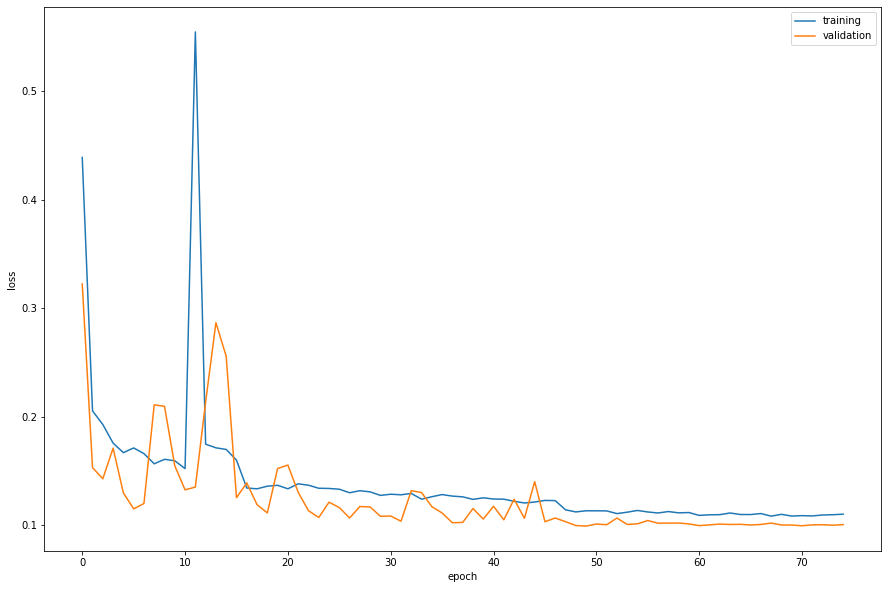

In [54]:
plotConvergence(history_embed.history, True)
#plt.ylim([0.,1])

plt.savefig('/Users/Mikkel/Desktop/embedConverge.png', bbox_inches = "tight", dpi = 300)

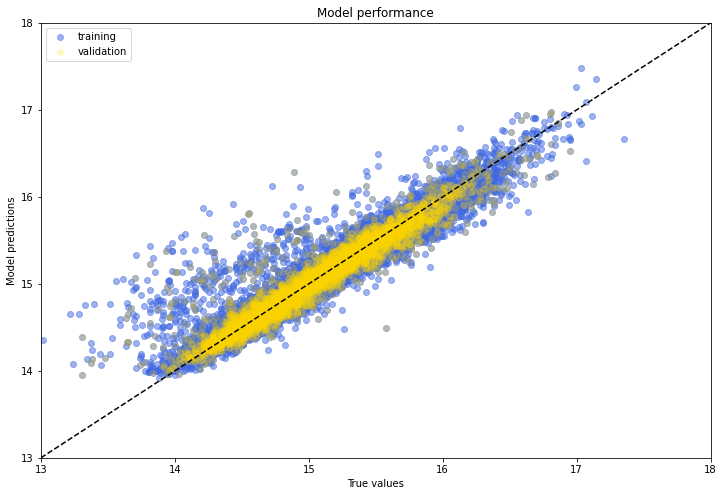

In [58]:
logY_train_ee_pred = model.predict(GetInputData(X_train)).reshape(-1)
logY_test_ee_pred = model.predict(GetInputData(X_val)).reshape(-1)

plt.figure(figsize = (12, 8))

plt.scatter(logY_train, logY_train_ee_pred, alpha=0.5, c = 'royalblue', label = 'training')
plt.scatter(logY_val, logY_test_ee_pred, alpha=0.2, c = 'gold', label = 'validation')
plt.legend(loc='upper left')
plt.plot([13, 18], [13, 18], ls="--", c="black")
plt.ylabel('Model predictions')
plt.xlabel('True values')
plt.xlim([13, 18])
plt.ylim([13, 18])

plt.title('Model performance')
plt.savefig('/Users/Mikkel/Desktop/embedPredict.png', bbox_inches = "tight", dpi = 300)

plt.show()

In [129]:
print('MAE: ', mean_absolute_error(logY_val, model.predict(GetInputData(X_val)).reshape(-1)))
print('MAPE: ', mean_absolute_percentage_error(y_val, np.exp(model.predict(GetInputData(X_val)).reshape(-1))))

MAE:  0.10037315978539084
MAPE:  0.1088181354719511


In [130]:
PercentWithinAlphaText(np.exp(model.predict(GetInputData(X_val)).reshape(-1)), y_val, 0.2)
PercentWithinAlphaText(np.exp(model.predict(GetInputData(X_val)).reshape(-1)), y_val, 0.15)
PercentWithinAlphaText(np.exp(model.predict(GetInputData(X_val)).reshape(-1)), y_val, 0.1)

90.61 % of predictions within  20.0 % of true value
82.0 % of predictions within  15.0 % of true value
65.7 % of predictions within  10.0 % of true value


In [171]:
cat_unit.get_vocabulary()

['Bolig i etageejendom, flerfamiliehus eller to-familiehus',
 'Fritliggende enfamiliehus',
 'Række-, kæde- og klyngehus',
 'Dobbelthus',
 'Række-, kæde- eller dobbelthus (lodret adskillelse mellem enhederne).']

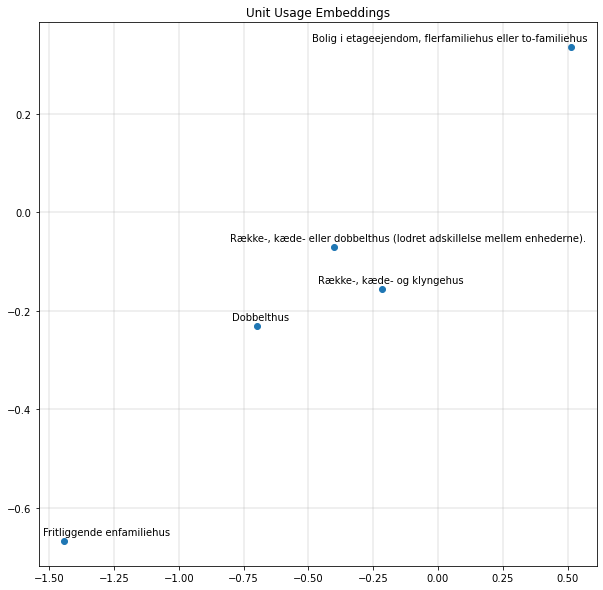

In [440]:
item = pd.DataFrame(model.get_layer('Embedding_unit').get_weights()[0])
voc = cat_unit.get_vocabulary()

x = item.iloc[:,0]
y = item.iloc[:,1]

fig, ax = plt.subplots(figsize = (10,10))
ax.scatter(x, y)
for i, txt in enumerate(voc):
    #ax.annotate(txt, (x[i], y[i]))
    if i <1:
        ax.annotate(txt, (x[i] - 1., y[i] + 0.012))
    elif i<2:
        ax.annotate(txt, (x[i] - 0.08, y[i] + 0.012))
    elif i<3:
        ax.annotate(txt, (x[i] - 0.25, y[i] + 0.012))
    elif i<4:
        ax.annotate(txt, (x[i] - 0.1, y[i] + 0.012))
    else:
        ax.annotate(txt, (x[i] - 0.4, y[i] + 0.012))
        
ax.grid(linewidth = .4)
ax.set_title('Unit Usage Embeddings')

fig.savefig('/Users/Mikkel/Desktop/unitEmbedding.png')

In [412]:
em_pca = PCA().fit_transform(model.get_layer('Embedding_energyMark').get_weights()[0])
em_pca.shape

(12, 6)

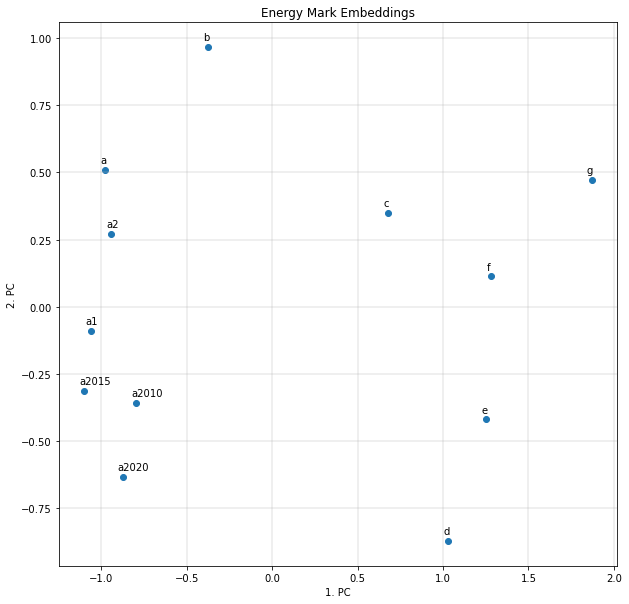

In [435]:
fig, ax = plt.subplots(figsize = (10,10))
ax.scatter(em_pca[:,0], em_pca[:,1])

voc = cat_em.get_vocabulary()

#areas = ['Østerbro', 'Sundbyvester', 'Indre by', 'Sundbyøster', 'Nørrebro']
#col = [if voc[i]]
for i, txt in enumerate(voc):
    ax.annotate(txt, (em_pca[i,0] - .03, em_pca[i,1] + 0.025))

ax.grid(linewidth = .4)
ax.set_xlabel('1. PC')
ax.set_ylabel('2. PC')
ax.set_title('Energy Mark Embeddings')

fig.savefig('/Users/Mikkel/Desktop/emEmbedding.png')

In [441]:
city_pca = PCA().fit_transform(model.get_layer('Embedding_city').get_weights()[0])
city_pca.shape

(14, 6)

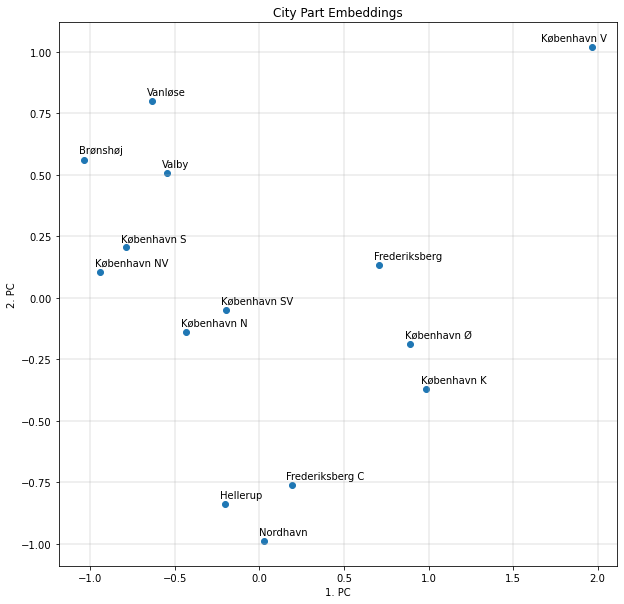

In [448]:
fig, ax = plt.subplots(figsize = (10,10))
ax.scatter(city_pca[:,0], city_pca[:,1])

voc = cat_city.get_vocabulary()

#areas = ['Østerbro', 'Sundbyvester', 'Indre by', 'Sundbyøster', 'Nørrebro']
#col = [if voc[i]]
for i, txt in enumerate(voc):
    if (txt == 'København V'):
        ax.annotate(txt, (city_pca[i,0] - .3, city_pca[i,1] + 0.025))
    else:
        ax.annotate(txt, (city_pca[i,0] - .03, city_pca[i,1] + 0.025))
ax.grid(linewidth = .4)
ax.set_xlabel('1. PC')
ax.set_ylabel('2. PC')
ax.set_title('City Part Embeddings')

fig.savefig('/Users/Mikkel/Desktop/cityEmbedding.png')

## Deep and wide NN's

In [53]:
input_city = keras.layers.Input(shape=[1], dtype = tf.string, name="cat_city")
input_item = keras.layers.Input(shape=[1], dtype = tf.string, name="cat_item")
input_em = keras.layers.Input(shape=[1], dtype = tf.string, name="cat_energyMark")
input_unit = keras.layers.Input(shape=[1], dtype = tf.string, name="cat_unit")
input_wall = keras.layers.Input(shape=[1], dtype = tf.string, name="cat_wall")
input_roof = keras.layers.Input(shape=[1], dtype = tf.string, name="cat_roof")
input_radon = keras.layers.Input(shape=[1], dtype = tf.string, name="cat_radon")
input_noise = keras.layers.Input(shape=[1], dtype = tf.string, name="cat_noise")
input_flood = keras.layers.Input(shape=[1], dtype = tf.string, name="cat_flooding")
input_party = keras.layers.Input(shape=[1], dtype = tf.string, name="cat_party")

input_num = keras.layers.Input(shape=[len(num_var)], name="num_input")

#categorical embeddings
cat1 = cat_city(input_city)
one1 = keras.layers.CategoryEncoding(len(cat_city.get_vocabulary()), output_mode="one_hot", name = 'OneHot_city')(cat1)

cat2 = cat_item(input_item)
one2 = keras.layers.CategoryEncoding(len(cat_item.get_vocabulary()), output_mode="one_hot", name = 'OneHot_item')(cat2)

cat3 = cat_em(input_em)
one3 = keras.layers.CategoryEncoding(len(cat_em.get_vocabulary()), output_mode="one_hot", name = 'OneHot_energyMark')(cat3)

cat4 = cat_unit(input_unit)
one4 = keras.layers.CategoryEncoding(len(cat_unit.get_vocabulary()), output_mode="one_hot", name = 'OneHot_unit')(cat4)

cat5 = cat_wall(input_wall)
one5 = keras.layers.CategoryEncoding(len(cat_wall.get_vocabulary()), output_mode="one_hot", name = 'OneHot_wall')(cat5)

cat6 = cat_roof(input_roof)
one6 = keras.layers.CategoryEncoding(len(cat_roof.get_vocabulary()), output_mode="one_hot", name = 'OneHot_roof')(cat6)

cat7 = cat_radon(input_radon)
one7 = keras.layers.CategoryEncoding(len(cat_radon.get_vocabulary()), output_mode="one_hot", name = 'OneHot_radon')(cat7)

cat8 = cat_noise(input_noise)
one8 = keras.layers.CategoryEncoding(len(cat_noise.get_vocabulary()), output_mode="one_hot", name = 'OneHot_noise')(cat8)

cat9 = cat_flood(input_flood)
one9 = keras.layers.CategoryEncoding(len(cat_flood.get_vocabulary()), output_mode="one_hot", name = 'OneHot_flooding')(cat9)

cat10 = cat_party(input_party)
one10 = keras.layers.CategoryEncoding(len(cat_party.get_vocabulary()), output_mode="one_hot", name = 'OneHot_party')(cat10)

#normalization of numerical variables
norm = keras.layers.BatchNormalization(name = 'Normalization')(input_num)



#concatenation of transformed inputs
input_all = keras.layers.concatenate([one1, one2, one3, one4, one5, one6,
                                      one7, one8, one9, one10, norm], name = 'all_inputs')

#hidden layers and output
hidden1 = keras.layers.Dense(50, activation="elu", kernel_initializer="he_normal", name = 'dense1')(input_all)

hidden2 = keras.layers.Dense(50, activation="elu", kernel_initializer="he_normal", name = 'dense2')(hidden1)

hidden3 = keras.layers.Dense(50, activation="elu", kernel_initializer="he_normal", name = 'dense3')(hidden2)

hidden4 = keras.layers.Dense(50, activation="elu", kernel_initializer="he_normal", name = 'dense4')(hidden3)

hidden5 = keras.layers.Dense(50, activation="elu", kernel_initializer="he_normal", name = 'dense5')(hidden4)

hidden6 = keras.layers.Dense(50, activation="elu", kernel_initializer="he_normal", name = 'dense6')(hidden5)

hidden7 = keras.layers.Dense(50, activation="elu", kernel_initializer="he_normal", name = 'dense7')(hidden6)

hidden8 = keras.layers.Dense(50, activation="elu", kernel_initializer="he_normal", name = 'dense8')(hidden7)

output = keras.layers.Dense(1, name="output")(hidden8)

#concatenation of deep and wide track
concat_ = keras.layers.concatenate([input_all, hidden8], name = 'concatenate')

#output
output = keras.layers.Dense(1, name="output")(concat_)

#Final model and compilation.
wad_model = keras.Model(inputs=[input_city, input_item, input_em, input_unit, input_wall, input_roof, 
                            input_radon, input_noise, input_flood, input_party, input_num], 
                    outputs=[output])

wad_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.005),
    loss='mean_absolute_error')

wad_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cat_city (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 cat_item (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 cat_energyMark (InputLayer)    [(None, 1)]          0           []                               
                                                                                                  
 cat_unit (InputLayer)          [(None, 1)]          0           []                               
                                                                                            

 ion)                                                                                             
                                                                                                  
 all_inputs (Concatenate)       (None, 96)           0           ['OneHot_city[0][0]',            
                                                                  'OneHot_item[0][0]',            
                                                                  'OneHot_energyMark[0][0]',      
                                                                  'OneHot_unit[0][0]',            
                                                                  'OneHot_wall[0][0]',            
                                                                  'OneHot_roof[0][0]',            
                                                                  'OneHot_radon[0][0]',           
                                                                  'OneHot_noise[0][0]',           
          

In [55]:
history_wad = wad_model.fit(GetInputData(X_train2), logY_train2,
                             epochs = 400, validation_data = (GetInputData(X_val), logY_val),
                             callbacks = [LR_scheduler, es_cb])

Epoch 1/400
593/593 [==============================] - 8s 10ms/step - loss: 0.4209 - val_loss: 0.2578 - lr: 0.0050
Epoch 2/400
593/593 [==============================] - 5s 8ms/step - loss: 0.1988 - val_loss: 0.1629 - lr: 0.0050
Epoch 3/400
593/593 [==============================] - 4s 6ms/step - loss: 0.1902 - val_loss: 0.2690 - lr: 0.0050
Epoch 4/400
593/593 [==============================] - 3s 5ms/step - loss: 0.1859 - val_loss: 0.1349 - lr: 0.0050
Epoch 5/400
593/593 [==============================] - 3s 5ms/step - loss: 0.3052 - val_loss: 0.1320 - lr: 0.0050
Epoch 6/400
593/593 [==============================] - 3s 5ms/step - loss: 0.1848 - val_loss: 0.1762 - lr: 0.0050
Epoch 7/400
593/593 [==============================] - 3s 6ms/step - loss: 0.1904 - val_loss: 0.1485 - lr: 0.0050
Epoch 8/400
593/593 [==============================] - 3s 4ms/step - loss: 0.1701 - val_loss: 0.1509 - lr: 0.0050
Epoch 9/400
593/593 [==============================] - 3s 5ms/step - loss: 0.1661 - val

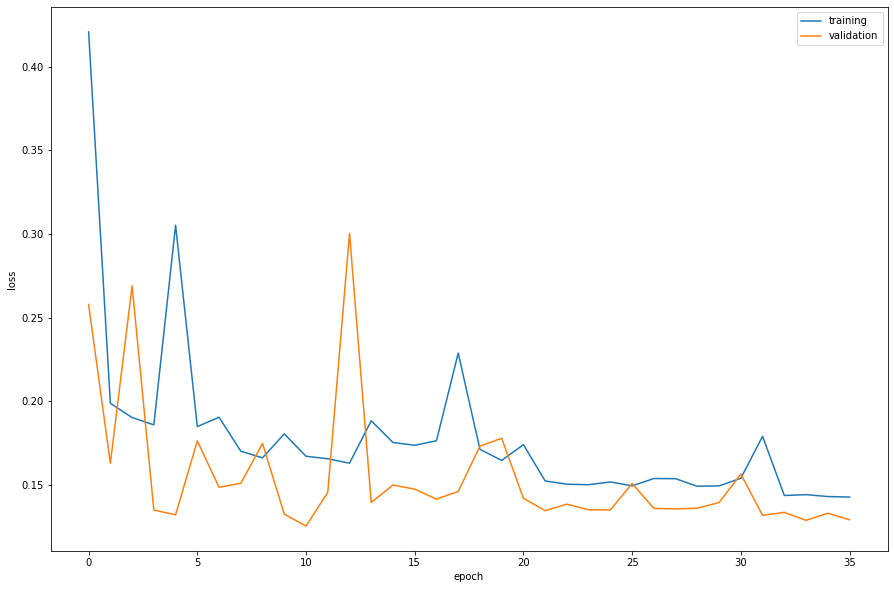

In [56]:
plotConvergence(history_wad.history, dropLR = True)
plt.savefig('/Users/Mikkel/Desktop/wadConverge.png', bbox_inches = "tight", dpi = 300)

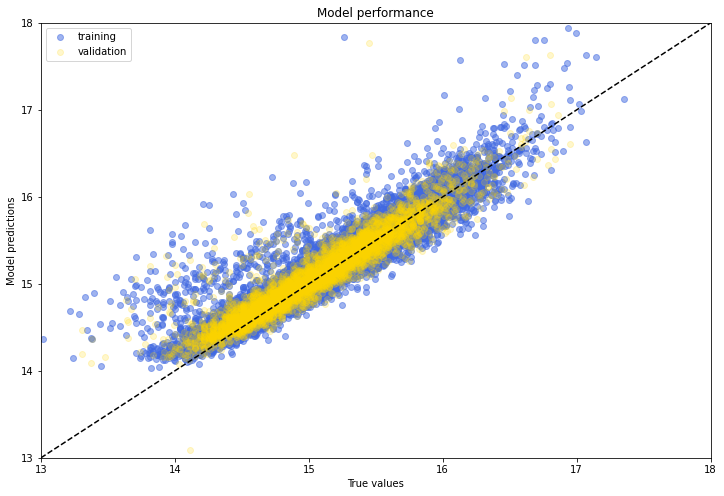

In [57]:
logY_train_ee_pred = wad_model.predict(GetInputData(X_train2)).reshape(-1)
logY_test_ee_pred = wad_model.predict(GetInputData(X_val)).reshape(-1)

plt.figure(figsize = (12, 8))

plt.scatter(logY_train2, logY_train_ee_pred, alpha=0.5, c = 'royalblue', label = 'training')
plt.scatter(logY_val, logY_test_ee_pred, alpha=0.2, c = 'gold', label = 'validation')
plt.legend(loc='upper left')
plt.plot([13, 18], [13, 18], ls="--", c="black")
plt.ylabel('Model predictions')
plt.xlabel('True values')
plt.xlim([13, 18])
plt.ylim([13, 18])

plt.title('Model performance')
plt.savefig('/Users/Mikkel/Desktop/wadPredict.png', bbox_inches = "tight", dpi = 300)

plt.show()

In [135]:
print('MAE: ', mean_absolute_error(logY_val, wad_model.predict(GetInputData(X_val)).reshape(-1)))
print('MAPE: ', mean_absolute_percentage_error(y_val, np.exp(wad_model.predict(GetInputData(X_val)).reshape(-1))))

MAE:  0.10049224508445305
MAPE:  0.10977077227356904


In [136]:
PercentWithinAlphaText(np.exp(wad_model.predict(GetInputData(X_val)).reshape(-1)), y_val, 0.2)
PercentWithinAlphaText(np.exp(wad_model.predict(GetInputData(X_val)).reshape(-1)), y_val, 0.15)
PercentWithinAlphaText(np.exp(wad_model.predict(GetInputData(X_val)).reshape(-1)), y_val, 0.1)

90.44 % of predictions within  20.0 % of true value
81.84 % of predictions within  15.0 % of true value
65.63 % of predictions within  10.0 % of true value


### Bagging

In [69]:
def buildEENN(m = 50, activ = 'elu', lr = 0.005, lossFunc = 'mean_absolute_error'):
    input_city = keras.layers.Input(shape=[1], dtype = tf.string, name="cat_city")
    input_item = keras.layers.Input(shape=[1], dtype = tf.string, name="cat_item")
    input_em = keras.layers.Input(shape=[1], dtype = tf.string, name="cat_energyMark")
    input_unit = keras.layers.Input(shape=[1], dtype = tf.string, name="cat_unit")
    input_wall = keras.layers.Input(shape=[1], dtype = tf.string, name="cat_wall")
    input_roof = keras.layers.Input(shape=[1], dtype = tf.string, name="cat_roof")
    input_radon = keras.layers.Input(shape=[1], dtype = tf.string, name="cat_radon")
    input_noise = keras.layers.Input(shape=[1], dtype = tf.string, name="cat_noise")
    input_flood = keras.layers.Input(shape=[1], dtype = tf.string, name="cat_flooding")
    input_party = keras.layers.Input(shape=[1], dtype = tf.string, name="cat_party")

    input_num = keras.layers.Input(shape=[len(num_var)], name="num_input")

    #categorical embeddings
    cat1 = cat_city(input_city)
    embed1 = keras.layers.Embedding(len(cat_city.get_vocabulary()), 6, name = 'Embedding_city')(cat1)
    flat1 = keras.layers.Flatten(input_shape = [1, 6], name = 'flatten_city')(embed1)

    cat2 = cat_item(input_item)
    embed2 = keras.layers.Embedding(len(cat_item.get_vocabulary()), 2, name = 'Embedding_item')(cat2)
    flat2 = keras.layers.Flatten(input_shape = [1, 2], name = 'flatten_item')(embed2)

    cat3 = cat_em(input_em)
    embed3 = keras.layers.Embedding(len(cat_em.get_vocabulary()), 6, name = 'Embedding_energyMark')(cat3)
    flat3 = keras.layers.Flatten(input_shape = [1, 6], name = 'flatten_energyMark')(embed3)

    cat4 = cat_unit(input_unit)
    embed4 = keras.layers.Embedding(len(cat_unit.get_vocabulary()), 2, name = 'Embedding_unit')(cat4)
    flat4 = keras.layers.Flatten(input_shape = [1, 2], name = 'flatten_unitUsage')(embed4)

    cat5 = cat_wall(input_wall)
    embed5 = keras.layers.Embedding(len(cat_wall.get_vocabulary()), 2, name = 'Embedding_wall')(cat5)
    flat5 = keras.layers.Flatten(input_shape = [1, 2], name = 'flatten_wall')(embed5)

    cat6 = cat_roof(input_roof)
    embed6 = keras.layers.Embedding(len(cat_roof.get_vocabulary()), 2, name = 'Embedding_roof')(cat6)
    flat6 = keras.layers.Flatten(input_shape = [1, 2], name = 'flatten_roof')(embed6)

    cat7 = cat_radon(input_radon)
    embed7 = keras.layers.Embedding(len(cat_radon.get_vocabulary()), 2, name = 'Embedding_radon')(cat7)
    flat7 = keras.layers.Flatten(input_shape = [1, 2], name = 'flatten_radonRisk')(embed7)

    cat8 = cat_noise(input_noise)
    embed8 = keras.layers.Embedding(len(cat_noise.get_vocabulary()), 2, name = 'Embedding_noise')(cat8)
    flat8 = keras.layers.Flatten(input_shape = [1, 2], name = 'flatten_noise')(embed8)

    cat9 = cat_flood(input_flood)
    embed9 = keras.layers.Embedding(len(cat_flood.get_vocabulary()), 2, name = 'Embedding_flooding')(cat9)
    flat9 = keras.layers.Flatten(input_shape = [1, 2], name = 'flatten_flooding')(embed9)

    cat10 = cat_party(input_party)
    embed10 = keras.layers.Embedding(len(cat_party.get_vocabulary()), 2, name = 'Embedding_party')(cat10)
    flat10 = keras.layers.Flatten(input_shape = [1, 2], name = 'flatten_party')(embed10)

    #normalization of numerical variables
    norm = keras.layers.BatchNormalization(name = 'Normalization')(input_num)



    #concatenation of transformed inputs
    input_all = keras.layers.concatenate([flat1, flat2, flat3, flat4, flat5, flat6,
                                          flat7, flat8, flat9, flat10, norm], name = 'concatenate')

    #hidden layers and output
    hidden1 = keras.layers.Dense(m, activation=activ, kernel_initializer="he_normal", name = 'dense1')(input_all)
    #norm1 = keras.layers.BatchNormalization()(hidden1)

    hidden2 = keras.layers.Dense(m, activation=activ, kernel_initializer="he_normal", name = 'dense2')(hidden1)
    #norm2 = keras.layers.BatchNormalization()(hidden2)

    hidden3 = keras.layers.Dense(m, activation=activ, kernel_initializer="he_normal", name = 'dense3')(hidden2)
    #norm3 = keras.layers.BatchNormalization()(hidden3)

    hidden4 = keras.layers.Dense(m, activation=activ, kernel_initializer="he_normal", name = 'dense4')(hidden3)
    #norm4 = keras.layers.BatchNormalization()(hidden4)

    hidden5 = keras.layers.Dense(m, activation=activ, kernel_initializer="he_normal", name = 'dense5')(hidden4)

    hidden6 = keras.layers.Dense(m, activation=activ, kernel_initializer="he_normal", name = 'dense6')(hidden5)

    hidden7 = keras.layers.Dense(m, activation=activ, kernel_initializer="he_normal", name = 'dense7')(hidden6)

    hidden8 = keras.layers.Dense(m, activation=activ, kernel_initializer="he_normal", name = 'dense8')(hidden7)

    output = keras.layers.Dense(1, name="output")(hidden8)

    #Final model and compilation.
    model = keras.Model(inputs=[input_city, input_item, input_em, input_unit, input_wall, input_roof, 
                                input_radon, input_noise, input_flood, input_party, input_num], 
                        outputs=[output])

    model.compile(optimizer=tf.optimizers.Adam(learning_rate=lr),
        loss=lossFunc)
    
    return model

In [70]:
def buildWAD(m = 50, activ = 'elu', lossFunc = 'mean_absolute_error'):
    input_city = keras.layers.Input(shape=[1], dtype = tf.string, name="cat_city")
    input_item = keras.layers.Input(shape=[1], dtype = tf.string, name="cat_item")
    input_em = keras.layers.Input(shape=[1], dtype = tf.string, name="cat_energyMark")
    input_unit = keras.layers.Input(shape=[1], dtype = tf.string, name="cat_unit")
    input_wall = keras.layers.Input(shape=[1], dtype = tf.string, name="cat_wall")
    input_roof = keras.layers.Input(shape=[1], dtype = tf.string, name="cat_roof")
    input_radon = keras.layers.Input(shape=[1], dtype = tf.string, name="cat_radon")
    input_noise = keras.layers.Input(shape=[1], dtype = tf.string, name="cat_noise")
    input_flood = keras.layers.Input(shape=[1], dtype = tf.string, name="cat_flooding")
    input_party = keras.layers.Input(shape=[1], dtype = tf.string, name="cat_party")

    input_num = keras.layers.Input(shape=[len(num_var)], name="num_input")

    #categorical embeddings
    cat1 = cat_city(input_city)
    one1 = keras.layers.CategoryEncoding(len(cat_city.get_vocabulary()), output_mode="one_hot", name = 'OneHot_city')(cat1)

    cat2 = cat_item(input_item)
    one2 = keras.layers.CategoryEncoding(len(cat_item.get_vocabulary()), output_mode="one_hot", name = 'OneHot_item')(cat2)

    cat3 = cat_em(input_em)
    one3 = keras.layers.CategoryEncoding(len(cat_em.get_vocabulary()), output_mode="one_hot", name = 'OneHot_energyMark')(cat3)

    cat4 = cat_unit(input_unit)
    one4 = keras.layers.CategoryEncoding(len(cat_unit.get_vocabulary()), output_mode="one_hot", name = 'OneHot_unit')(cat4)

    cat5 = cat_wall(input_wall)
    one5 = keras.layers.CategoryEncoding(len(cat_wall.get_vocabulary()), output_mode="one_hot", name = 'OneHot_wall')(cat5)

    cat6 = cat_roof(input_roof)
    one6 = keras.layers.CategoryEncoding(len(cat_roof.get_vocabulary()), output_mode="one_hot", name = 'OneHot_roof')(cat6)

    cat7 = cat_radon(input_radon)
    one7 = keras.layers.CategoryEncoding(len(cat_radon.get_vocabulary()), output_mode="one_hot", name = 'OneHot_radon')(cat7)

    cat8 = cat_noise(input_noise)
    one8 = keras.layers.CategoryEncoding(len(cat_noise.get_vocabulary()), output_mode="one_hot", name = 'OneHot_noise')(cat8)

    cat9 = cat_flood(input_flood)
    one9 = keras.layers.CategoryEncoding(len(cat_flood.get_vocabulary()), output_mode="one_hot", name = 'OneHot_flooding')(cat9)

    cat10 = cat_party(input_party)
    one10 = keras.layers.CategoryEncoding(len(cat_party.get_vocabulary()), output_mode="one_hot", name = 'OneHot_party')(cat10)

    #normalization of numerical variables
    norm = keras.layers.BatchNormalization(name = 'Normalization')(input_num)



    #concatenation of transformed inputs
    input_all = keras.layers.concatenate([one1, one2, one3, one4, one5, one6,
                                          one7, one8, one9, one10, norm], name = 'all_inputs')

    #hidden layers and output
    hidden1 = keras.layers.Dense(m, activation=activ, kernel_initializer="he_normal", name = 'dense1')(input_all)

    hidden2 = keras.layers.Dense(m, activation=activ, kernel_initializer="he_normal", name = 'dense2')(hidden1)

    hidden3 = keras.layers.Dense(m, activation=activ, kernel_initializer="he_normal", name = 'dense3')(hidden2)

    hidden4 = keras.layers.Dense(m, activation=activ, kernel_initializer="he_normal", name = 'dense4')(hidden3)

    hidden5 = keras.layers.Dense(m, activation=activ, kernel_initializer="he_normal", name = 'dense5')(hidden4)

    hidden6 = keras.layers.Dense(m, activation=activ, kernel_initializer="he_normal", name = 'dense6')(hidden5)

    hidden7 = keras.layers.Dense(m, activation=activ, kernel_initializer="he_normal", name = 'dense7')(hidden6)

    hidden8 = keras.layers.Dense(m, activation=activ, kernel_initializer="he_normal", name = 'dense8')(hidden7)

    output = keras.layers.Dense(1, name="output")(hidden8)

    #concatenation of deep and wide track
    concat_ = keras.layers.concatenate([input_all, hidden8], name = 'concatenate')

    #output
    output = keras.layers.Dense(1, name="output")(concat_)

    #Final model and compilation.
    model = keras.Model(inputs=[input_city, input_item, input_em, input_unit, input_wall, input_roof, 
                                input_radon, input_noise, input_flood, input_party, input_num], 
                        outputs=[output])

    model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.005),
        loss=lossFunc)
    
    return model


In [71]:
class ANN:
    def __init__(self, model = 'DNN', replace = True, frac = 1, n = 5, l = 9, m = 50, actfnct = 'elu', 
                 norm = False, loss = 'mean_absolute_error'):
        assert model in ['DNN', 'WAD', 'EE'], 'model be one of types [DNN, WAD, EE]'
        assert frac <= 1 or replace == True, 'Fraction cannot be larger than 1 when sampling without replacement'
             
        
        self.models = list()
        self.X_i = list()
        self.y_i = list()
        self.n = n
        self.type = model
        self.frac = frac
        self.replace = replace
        for i in range(n):
            if model == 'DNN':
                mod = buildDnn(l, m, activ = actfnct, normalize_all_layers = norm, learning_rate = 0.005, lossFunc = loss)
            elif model == 'WAD':
                mod = buildWAD(m, activ = actfnct, lossFunc = loss)
            else:
                mod = buildEENN(m, activ = actfnct, lossFunc = loss)
                
            self.models.append(mod)
        
        
    def fit(self, X, y, verbose = 1):  
        
        n_i = math.ceil(self.frac * len(X))
        self.index = list()
        for i in range(self.n):
            if self.replace:
                index = random.choices(np.arange(len(X)), k = n_i)
            else:
                index = random.sample(range(len(X)), n_i)
                
            if self.type == 'DNN':
                self.X_i.append(X[index])
            else:
                self.X_i.append(X.iloc[index, :])
            self.y_i.append(y[index])
            
            
        i = 0
        for model in self.models:
            if verbose > 0:
                print(f'fitting {self.type} model {i + 1} out of {self.n}')
            if self.type == 'DNN':
                model.fit(self.X_i[i], self.y_i[i],
                          validation_data= (X_val_scaled, logY_val),
                          verbose=0, 
                          epochs=400,
                          callbacks = [LR_scheduler, es_cb])
            else:
                model.fit(GetInputData(self.X_i[i]), self.y_i[i],
                          validation_data= (GetInputData(X_val), logY_val),
                          verbose=0, 
                          epochs=400,
                          callbacks = [LR_scheduler, es_cb])
            i += 1
        if verbose > 0:
            print('All models are fit')
        
    def predict(self, X):
        y = np.repeat(0., len(X))
        for model in self.models:
            if self.type == 'DNN':
                y += model.predict(X).reshape(-1)
            else:
                y += model.predict(GetInputData(X)).reshape(-1)
            
        return y/self.n
        



In [637]:
ns = [5,10,15,20]
scoresPasting = list()
cv = KFold(n_splits=5)
for n in ns:
    print(f'n={n}')
    score = []
    for train_index, val_index in cv.split(X_train2):
        paste = ANN(n = n, replace = False, frac = 1)
        paste.fit(X_train2_scaled[train_index, :], logY_train2[train_index])
        score.append(mean_absolute_error(logY_train2[val_index], paste.predict(X_train2_scaled[val_index,:])))
        
    scoresPasting.append(score)

n=5
fitting DNN model 1 out of 5
fitting DNN model 2 out of 5
fitting DNN model 3 out of 5
fitting DNN model 4 out of 5
fitting DNN model 5 out of 5
All models are fit
fitting DNN model 1 out of 5
fitting DNN model 2 out of 5
fitting DNN model 3 out of 5
fitting DNN model 4 out of 5
fitting DNN model 5 out of 5
All models are fit
fitting DNN model 1 out of 5
fitting DNN model 2 out of 5
fitting DNN model 3 out of 5
fitting DNN model 4 out of 5
fitting DNN model 5 out of 5
All models are fit
fitting DNN model 1 out of 5
fitting DNN model 2 out of 5
fitting DNN model 3 out of 5
fitting DNN model 4 out of 5
fitting DNN model 5 out of 5
All models are fit
fitting DNN model 1 out of 5
fitting DNN model 2 out of 5
fitting DNN model 3 out of 5
fitting DNN model 4 out of 5
fitting DNN model 5 out of 5
All models are fit
n=10
fitting DNN model 1 out of 10
fitting DNN model 2 out of 10
fitting DNN model 3 out of 10
fitting DNN model 4 out of 10
fitting DNN model 5 out of 10
fitting DNN model 6 o

4
4
4


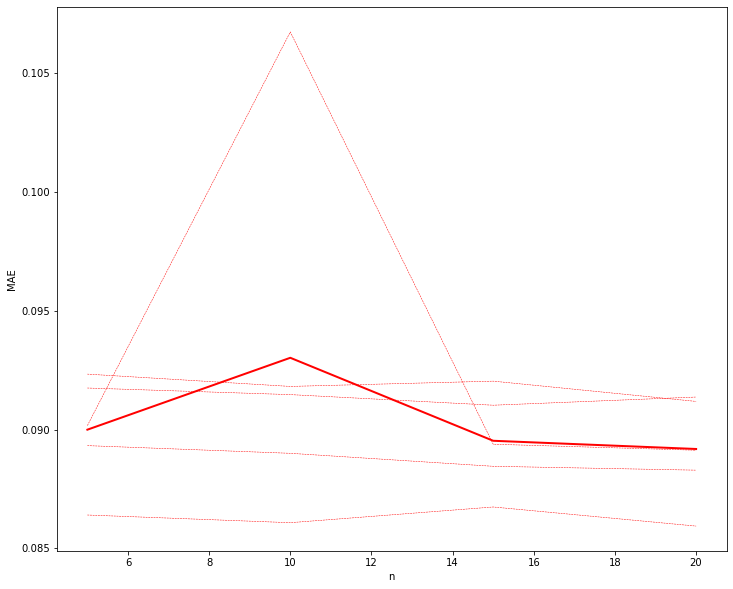

In [638]:
maes = np.vstack(scoresPasting)
means = np.mean(maes, axis = 1)

print(len(ns))
print(len(maes))
print(len(means))
fig, ax = plt.subplots(figsize = (12,10))


for i in range(5):
    ax.plot(ns, maes[:,i], '--', linewidth=0.5, c='red')

ax.plot(ns, means, linewidth=2, c='red')    

plt.xlabel('n')
plt.ylabel('MAE')

plt.savefig('/Users/Mikkel/Desktop/pastingTuning.png')

plt.show()

In [267]:
ann = ANN(n = 5, replace = False, frac = 1)
ann.fit(X_train2_scaled, logY_train2)

fitting DNN model 1 out of 5
fitting DNN model 2 out of 5
fitting DNN model 3 out of 5
fitting DNN model 4 out of 5
fitting DNN model 5 out of 5
All models are fit


In [268]:
average_pred = ann.predict(X_val_scaled)

In [269]:
print('MAE n=5: ', mean_absolute_error(logY_val, average_pred))
print('MAPE n=5: ', mean_absolute_percentage_error(y_val, np.exp(average_pred)))

MAE n=5:  0.0892683608329241
MAPE n=5:  0.09878806718152819


In [270]:
print('n = 5')
PercentWithinAlphaText(np.exp(average_pred), y_val, 0.2)
PercentWithinAlphaText(np.exp(average_pred), y_val, 0.15)
PercentWithinAlphaText(np.exp(average_pred), y_val, 0.1)

n = 5
92.59 % of predictions within  20.0 % of true value
86.65 % of predictions within  15.0 % of true value
72.59 % of predictions within  10.0 % of true value


In [144]:
bag_ee = ANN(model = 'EE', n = 5, replace = True)
bag_ee.fit(X_train2, logY_train2)

fitting EE model 1 out of 5
fitting EE model 2 out of 5
fitting EE model 3 out of 5
fitting EE model 4 out of 5
fitting EE model 5 out of 5
All models are fit


In [145]:
print('EE MAE:', mean_absolute_error(logY_val, bag_ee.predict(X_val)))

EE MAE: 0.09650982550558646


In [266]:
bag_wad = ANN(model = 'WAD', n = 5, replace = False)
bag_wad.fit(X_train2, logY_train2)
print('WAD MAE:', mean_absolute_error(logY_val, bag_wad.predict(X_val)))

fitting WAD model 1 out of 5
fitting WAD model 2 out of 5
fitting WAD model 3 out of 5
fitting WAD model 4 out of 5
fitting WAD model 5 out of 5
All models are fit
WAD MAE: 0.09952645608744691


## Super Learner

In [304]:
def get_models():
    models = list()
    models.append(LinearRegression())
    models.append(RandomForestRegressor(n_estimators = 40, criterion = 'absolute_error'))
    models.append(ANN(n = 5, replace = False, frac = 1))
    models.append(ANN(model = 'EE', n = 5, replace = False, frac = 1))
    models.append(ANN(model = 'WAD', n = 5, replace = False, frac = 1))
    return models

def fit_meta_model(X, y):
    model = LinearRegression()
    
    def MAE(alpha):
        yhat = np.matmul(alpha.reshape((1,5)), X.T).reshape(-1)
        return mean_absolute_error(y, yhat)
    
    #setting up contraints on the minimization problem
    bounds = Bounds(np.repeat(0, 5), np.repeat(1, 5))
    constraint = LinearConstraint(np.repeat(1,5), [1], [1])
    
    print('Fitting meta model')
    
    #finding coefficients by constrained minimization
    res = minimize(MAE, np.repeat(1/5, 5), method='trust-constr',
                   constraints=[constraint],
                   options={'verbose': 0}, bounds=bounds)
    
    model.intercept_ = 0
    model.coef_ = res.x
    print('Meta model fitted')
    return model    

In [305]:
class super_learner:
    def __init__(self):
        self.models = get_models()
        self.meta_model = LinearRegression()
    
    def fit_library_models(self, X, y):
        i = 0
        for model in self.models:
            if (i < 3):
                X_temp = pipe.transform(pd.get_dummies(X, columns=cat_var, drop_first=True))
                model.fit(X_temp, y)
            else:
                model.fit(X, y)
            i += 1
        
    def fit(self, X, y, v = 5):
        meta_X, meta_y = list(), list()
        
        cv = KFold(n_splits=v)
        
        v=1
        for train_ix, test_ix in cv.split(X):
            print(f'Making out-of-sample predictions for v={v}')
            i = 0
            fold_yhats = list()
            train_X, test_X = X.iloc[train_ix, :], X.iloc[test_ix, :]
            train_y, test_y = y[train_ix], y[test_ix]
            meta_y.extend(test_y)
            
            mods = get_models()
            for model in mods:
                if (i < 3):
                    train_X_temp = pd.get_dummies(train_X, columns=cat_var, drop_first=True)
                    test_X_test = pd.get_dummies(test_X, columns=cat_var, drop_first=True)
                    
                    model.fit(pipe.transform(train_X_temp), train_y)
                    yhat = model.predict(pipe.transform(test_X_test))
                else:
                    model.fit(train_X, train_y, verbose = 0)
                    yhat = model.predict(test_X)
                    
                fold_yhats.append(yhat.reshape(len(yhat),1))
                i += 1
                
            meta_X.append(np.hstack(fold_yhats))
            v +=1
        
        self.meta_model = fit_meta_model(np.vstack(meta_X), np.asarray(meta_y))
        
        self.fit_library_models(X, y)
        
    
    def predict(self, X):
        meta_X = list()
        
        i = 0
        for model in self.models:
            if (i < 3):
                X_temp = pd.get_dummies(X, columns=cat_var, drop_first=True)
                yhat = model.predict(pipe.transform(X_temp))
            else:
                yhat = model.predict(X)
            
            meta_X.append(yhat.reshape(len(yhat),1))
            i += 1
            
        meta_X = np.hstack(meta_X)
        return self.meta_model.predict(meta_X)
    
    def get_weights(self):
        return  pd.DataFrame(np.array(self.meta_model.coef_).reshape((1,5)), columns = ['OLS', 'Random Forest', 
                                                            'Neural Network','Entity Embedding', 'Wide and Deep'])
    
    def score(self, X, y, method ='MAE'):
        assert method in ['MAE', 'MSE', 'MAPE'], 'method must be in [MAE, MSE, MAPE]'
        assert len(X) == len(y), 'lenght of X and y must be equal'
        
        if method == 'MAE':
            return mean_absolute_error(y, self.predict(X))
        elif method == 'MSE':
            return mean_squared_error(y, self.predict(X))
        else:
            return mean_absolute_percentage_error(y, np.exp(self.predict(X)))
        
    def evaluate_models(self, X, y, method ='MAE'):
        assert method in ['MAE', 'MSE', 'MAPE'], 'method must be in [MAE, MSE, MAPE]'
        assert len(X) == len(y), 'lenght of X and y must be equal'
        
        error = self.score(X, y, method = method)
        print('Super learner: %s %.6f' % (method, error))
        
        i = 0
        for model in self.models:
            if (i < 1):
                X_temp = pd.get_dummies(X, columns=cat_var, drop_first=True)
                yhat = model.predict(pipe.transform(X_temp))
                name = 'Linear regression'
            elif (i < 2):
                X_temp = pd.get_dummies(X, columns=cat_var, drop_first=True)
                yhat = model.predict(pipe.transform(X_temp))
                name = 'Random forest'
            elif (i < 3):
                X_temp = pd.get_dummies(X, columns=cat_var, drop_first=True)
                yhat = model.predict(pipe.transform(X_temp))
                name = 'DNN'
            elif (i<4):
                yhat = model.predict(X)
                name = 'EE DNN'
            else:
                yhat = model.predict(X)
                name = 'Wide and Deep DNN'
                            
            if method == 'MAE':
                error = mean_absolute_error(y, yhat)
            elif method == 'MSE':
                error = mean_squared_error(y, yhat)
            else:
                error = mean_absolute_percentage_error(y, np.exp(yhat))

            print('%s: %s %.6f' % (name, method, error))
            i += 1
        

In [74]:
sl = super_learner()
sl.fit(X_train2, logY_train2, v=10)

Making out-of-sample predictions for v=1
Making out-of-sample predictions for v=2
Making out-of-sample predictions for v=3
Making out-of-sample predictions for v=4
Making out-of-sample predictions for v=5
Making out-of-sample predictions for v=6
Making out-of-sample predictions for v=7
Making out-of-sample predictions for v=8
Making out-of-sample predictions for v=9
Making out-of-sample predictions for v=10
Fitting meta model


/Users/Mikkel/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/Users/Mikkel/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/Users/Mikkel/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the H

Meta model fitted
fitting DNN model 1 out of 5
fitting DNN model 2 out of 5
fitting DNN model 3 out of 5
fitting DNN model 4 out of 5
fitting DNN model 5 out of 5
All models are fit
fitting EE model 1 out of 5
fitting EE model 2 out of 5
fitting EE model 3 out of 5
fitting EE model 4 out of 5
fitting EE model 5 out of 5
All models are fit
fitting WAD model 1 out of 5
fitting WAD model 2 out of 5
fitting WAD model 3 out of 5
fitting WAD model 4 out of 5
fitting WAD model 5 out of 5
All models are fit


In [75]:
sl.get_weights()

,OLS,Random Forest,Neural Network,Entity Embedding,Wide and Deep
0,0.000623,0.135514,0.791445,0.00103,0.071387


In [271]:
print('MAE: ', sl.score(X_val, logY_val))
print('MAPE: ', sl.score(X_val, y_val, method = 'MAPE'))

MAE:  0.08894712593365407
MAPE:  0.09804374414897385


In [272]:
logY_test_sl_pred = sl.predict(X_val)
PercentWithinAlphaText(np.exp(logY_test_sl_pred), y_val, 0.2)
PercentWithinAlphaText(np.exp(logY_test_sl_pred), y_val, 0.15)
PercentWithinAlphaText(np.exp(logY_test_sl_pred), y_val, 0.1)

92.57 % of predictions within  20.0 % of true value
86.62 % of predictions within  15.0 % of true value
72.15 % of predictions within  10.0 % of true value


In [183]:
sl.evaluate_models(X_val, logY_val, method = 'MAE')
print()
sl.evaluate_models(X_val, y_val, method = 'MAPE')
print()

i = 0
for model in sl.models:
    if (i < 1):
        X_temp = pd.get_dummies(X_val, columns=cat_var, drop_first=True)
        yhat = model.predict(pipe.transform(X_temp))
        name = 'Linear regression'
    elif (i < 2):
        yhat = model.predict(rfpipe.transform(X_val))
        name = 'Random forest'
    elif (i < 3):
        X_temp = pd.get_dummies(X_val, columns=cat_var, drop_first=True)
        yhat = model.predict(pipe.transform(X_temp))
        name = 'DNN'
    elif (i<4):
        yhat = model.predict(X_val)
        name = 'EE DNN'
    else:
        yhat = model.predict(X_val)
        name = 'Wide and Deep DNN'

    error10 = PercentWithinAlpha(np.exp(yhat), y_val, 0.1)
    error15 = PercentWithinAlpha(np.exp(yhat), y_val, 0.15)
    error20 = PercentWithinAlpha(np.exp(yhat), y_val, 0.2)
    
    print('%s: 10p %.4f, 15p %.4f, 20p %.4f' % (name, error10, error15, error20))
    
    
    i += 1

Linear regression: MAE 0.5021
Random forest: MAE 0.6527
DNN: MAE 0.7196
EE DNN: MAE 0.6854
Wide and Deep DNN: MAE 0.6665


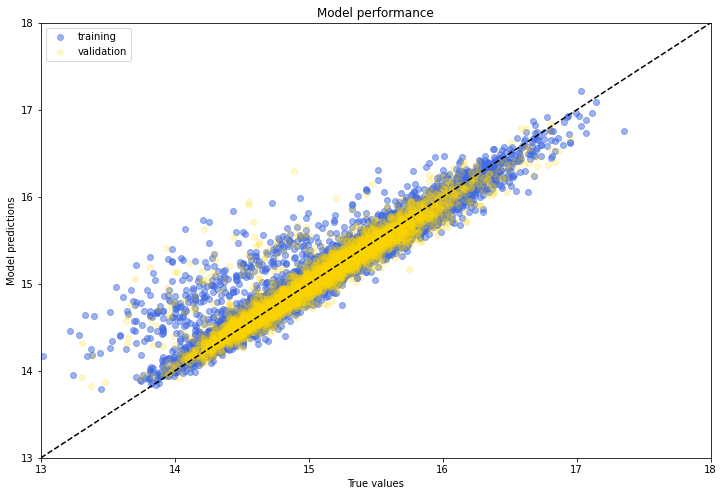

In [302]:
logY_train_sl_pred = sl.predict(X_train2)

plt.figure(figsize = (12, 8))

plt.scatter(logY_train2, logY_train_sl_pred, alpha=0.5, c = 'royalblue', label = 'training')
plt.scatter(logY_val, logY_test_sl_pred, alpha=0.2, c = 'gold', label = 'validation')
plt.plot([13, 18], [13, 18], ls="--", c="black")
plt.legend(loc='upper left')
plt.ylabel('Model predictions')
plt.xlabel('True values')
plt.xlim([13, 18])
plt.ylim([13, 18])

plt.title('Model performance')

plt.savefig('/Users/Mikkel/Desktop/slPredict.png')

plt.show()

## Performance on Test Set

In [ ]:
final_model = super_learner()
final_model.fit(X_train, logY_train, v=10)

Making out-of-sample predictions for v=1
fitting DNN model 1 out of 5
fitting DNN model 2 out of 5
fitting DNN model 3 out of 5
fitting DNN model 4 out of 5
fitting DNN model 5 out of 5
All models are fit
Making out-of-sample predictions for v=2
fitting DNN model 1 out of 5
fitting DNN model 2 out of 5
fitting DNN model 3 out of 5
fitting DNN model 4 out of 5
fitting DNN model 5 out of 5
All models are fit
Making out-of-sample predictions for v=3
fitting DNN model 1 out of 5
fitting DNN model 2 out of 5
fitting DNN model 3 out of 5
fitting DNN model 4 out of 5
fitting DNN model 5 out of 5
All models are fit
Making out-of-sample predictions for v=4
fitting DNN model 1 out of 5
fitting DNN model 2 out of 5
fitting DNN model 3 out of 5
fitting DNN model 4 out of 5
fitting DNN model 5 out of 5
All models are fit
Making out-of-sample predictions for v=5
fitting DNN model 1 out of 5
fitting DNN model 2 out of 5
fitting DNN model 3 out of 5
fitting DNN model 4 out of 5
fitting DNN model 5 out

/Users/Mikkel/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/Users/Mikkel/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/Users/Mikkel/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the H

Meta model fitted
fitting DNN model 1 out of 5
fitting DNN model 2 out of 5
fitting DNN model 3 out of 5
fitting DNN model 4 out of 5
fitting DNN model 5 out of 5
All models are fit
fitting EE model 1 out of 5
fitting EE model 2 out of 5
fitting EE model 3 out of 5
fitting EE model 4 out of 5
fitting EE model 5 out of 5
All models are fit
fitting WAD model 1 out of 5
fitting WAD model 2 out of 5


In [187]:
final_model.get_weights()

,OLS,Random Forest,Neural Network,Entity Embedding,Wide and Deep
0,0.000274,0.288228,0.000046,0.711222,0.00023


In [227]:
print('MAE:')
final_model.evaluate_models(X_test, logY_test, method = 'MAE')
print()
print('MAPE:')
final_model.evaluate_models(X_test, y_test, method = 'MAPE')

MAE:
Super learner: MAE 0.088427
Linear regression: MAE 0.131986
Random forest: MAE 0.099763
DNN: MAE 4.408755
EE DNN: MAE 0.090981
Wide and Deep DNN: MAE 0.412139

MAPE:
Super learner: MAE 0.094253
Linear regression: MAPE 0.142354
Random forest: MAPE 0.104388
DNN: MAPE 0.092252
EE DNN: MAPE 0.097324
Wide and Deep DNN: MAPE 0.098803


In [215]:
i = 0
for model in final_model.models:
    if (i < 1):
        X_temp = pd.get_dummies(X_test, columns=cat_var, drop_first=True)
        yhat = model.predict(pipe.transform(X_temp))
        name = 'Linear regression'
    elif (i < 2):
        yhat = model.predict(rfpipe.transform(X_test))
        name = 'Random forest'
    elif (i < 3):
        X_temp = pd.get_dummies(X_test, columns=cat_var, drop_first=True)
        yhat = model.predict(pipe.transform(X_temp))
        name = 'DNN'
    elif (i<4):
        yhat = model.predict(X_test)
        name = 'EE DNN'
    else:
        yhat = model.predict(X_test)
        name = 'Wide and Deep DNN'

    error10 = PercentWithinAlpha(np.exp(yhat), y_test, 0.1)
    error15 = PercentWithinAlpha(np.exp(yhat), y_test, 0.15)
    error20 = PercentWithinAlpha(np.exp(yhat), y_test, 0.2)
    
    print('%s: 10p %.4f, 15p %.4f, 20p %.4f' % (name, error10, error15, error20))
    
    
    i += 1

Linear regression: MAE 0.6937
Random forest: MAE 0.8152
DNN: MAE 0.8732
EE DNN: MAE 0.8513
Wide and Deep DNN: MAE 0.8493


In [229]:
yhat = final_model.models[2].predict(pipe.transform(pd.get_dummies(X_test, columns=cat_var, drop_first=True)))
ind = np.abs(logY_test - yhat).argmax()

pd.DataFrame(np.abs(logY_test - yhat)).sort_values(by = 0).tail(10)

,0
2404,1.674377
3967,2.343809
5543,7.856303
2748,25.291700
1308,49.545896
4447,447.647534
982,1019.344982
847,2455.416806
4347,5353.898179
5476,16262.966425


In [214]:
print(yhat[ind])
print(y_test[ind])
X_test.iloc[ind, :]

-16247.23399181366
6800000.0


city_b                                                       København K
propertyValuation_b                                            2250000.0
itemTypeName_b                                             Ejerlejlighed
buildYear_b                                                         1805
areaParcel_b                                                         0.0
numberOfFloors_b                                                     4.0
floor_b                                                              0.0
energyMark_b                                                           d
SalesPeriod_b                                                       18.0
numberOfToilets_b                                                    1.0
numberOfBathrooms_b                                                  1.0
rebuildYear_bd                                                      1805
areaBasement_bd                                                      0.0
areaWeighted_bd                                    

In [213]:
logY_test_final_pred = sl.predict(X_test)
PercentWithinAlphaText(np.exp(logY_test_final_pred), y_test, 0.2)
PercentWithinAlphaText(np.exp(logY_test_final_pred), y_test, 0.15)
PercentWithinAlphaText(np.exp(logY_test_final_pred), y_test, 0.1)

93.45 % of predictions within  20.0 % of true value
87.21 % of predictions within  15.0 % of true value
72.47 % of predictions within  10.0 % of true value


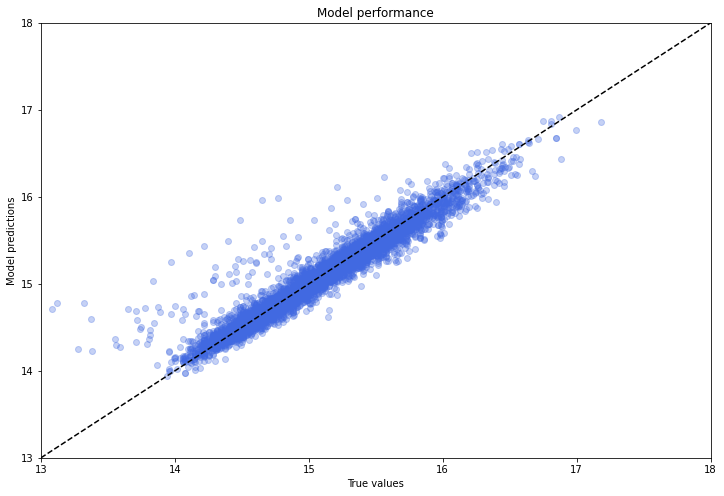

In [191]:
plt.figure(figsize = (12, 8))

plt.scatter(logY_test, logY_test_final_pred, alpha=0.3, c = 'royalblue')
plt.plot([13, 18], [13, 18], ls="--", c="black")
plt.ylabel('Model predictions')
plt.xlabel('True values')
plt.xlim([13, 18])
plt.ylim([13, 18])

plt.title('Model performance')

plt.savefig('/Users/Mikkel/Desktop/finalPredict.png')

plt.show()

# AVM prices


In [20]:
avm_data = pd.read_csv("modelling_data.csv", parse_dates=['saleDate_b','valuationDate_b'])
avm = np.array(avm_data.loc[:, ['AVM_price_d']])
y = np.array(avm_data.loc[:, ['salePrice_b']])

for train_index, test_index in split.split(X, X[["itemTypeName_b"]]):
    avm_train = avm[train_index]
    avm_test = avm[test_index]
    y_train = y[train_index]
    y_test = y[test_index]

In [255]:
print('MAE: ',mean_absolute_error(np.log(y_test), np.log(avm_test.reshape(-1))))
print('MAPE: ', mean_absolute_percentage_error(y_test, avm_test.reshape(-1)))

MAE:  0.1593217294213481
MAPE:  0.1834873698709708


In [256]:
print(avm_test.reshape(-1))
print(y_test.reshape(-1))

[ 4998086.  4476168.  1899092. ... 10793988.  3524974.  4257615.]
[3350000. 3515000. 1375000. ... 9850000. 2450000. 3750000.]


In [257]:
PercentWithinAlphaText(avm_test.reshape(-1), y_test.reshape(-1), 0.2)
PercentWithinAlphaText(avm_test.reshape(-1), y_test.reshape(-1), 0.15)
PercentWithinAlphaText(avm_test.reshape(-1), y_test.reshape(-1), 0.1)

64.01 % of predictions within  20.0 % of true value
46.98 % of predictions within  15.0 % of true value
35.57 % of predictions within  10.0 % of true value


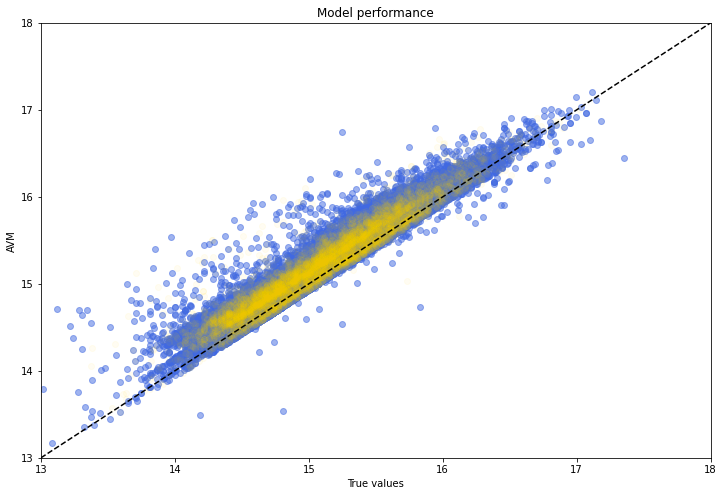

In [258]:
plt.figure(figsize = (12, 8))

plt.scatter(np.log(y_train.reshape(-1)), np.log(avm_train.reshape(-1)), alpha=0.5, c = 'royalblue')
plt.scatter(np.log(y_test.reshape(-1)), np.log(avm_test.reshape(-1)), alpha=0.05, c = 'gold')
plt.plot([13, 18], [13, 18], ls="--", c="black")
plt.ylabel('AVM')
plt.xlabel('True values')
plt.xlim([13, 18])
plt.ylim([13, 18])

plt.title('Model performance')

plt.savefig('/Users/Mikkel/Desktop/avm.png')

plt.show()

In [259]:
print('Before 2021:')
avm = np.array(avm_data.loc[avm_data['saleDate_b']  < '2021-01-01', ['AVM_price_d']])
y = np.array(avm_data.loc[avm_data['saleDate_b']  < '2021-01-01', ['salePrice_b']])

print('MAE: ',mean_absolute_error(np.log(y), np.log(avm.reshape(-1))))
print('MAPE: ', mean_absolute_percentage_error(y, avm.reshape(-1)))

PercentWithinAlphaText(avm.reshape(-1), y.reshape(-1), 0.2)
PercentWithinAlphaText(avm.reshape(-1), y.reshape(-1), 0.15)
PercentWithinAlphaText(avm.reshape(-1), y.reshape(-1), 0.1)

print('After 2021:')
avm = np.array(avm_data.loc[avm_data['saleDate_b']  >= '2021-01-01', ['AVM_price_d']])
y = np.array(avm_data.loc[avm_data['saleDate_b']  >= '2021-01-01', ['salePrice_b']])

print('Observations: ', len(y))

print('MAE: ',mean_absolute_error(np.log(y), np.log(avm.reshape(-1))))
print('MAPE: ', mean_absolute_percentage_error(y, avm.reshape(-1)))

PercentWithinAlphaText(avm.reshape(-1), y.reshape(-1), 0.2)
PercentWithinAlphaText(avm.reshape(-1), y.reshape(-1), 0.15)
PercentWithinAlphaText(avm.reshape(-1), y.reshape(-1), 0.1)

PercentWithinAlphaText(avm.reshape(-1), y.reshape(-1), 0.05)

Before 2021:
MAE:  0.19688477303503565
MAPE:  0.22731613997832975
53.49 % of predictions within  20.0 % of true value
30.59 % of predictions within  15.0 % of true value
16.22 % of predictions within  10.0 % of true value
After 2021:
Observations:  7067
MAE:  0.0361063120395355
MAPE:  0.03714729025756251
99.31 % of predictions within  20.0 % of true value
99.04 % of predictions within  15.0 % of true value
96.39 % of predictions within  10.0 % of true value
74.12 % of predictions within  5.0 % of true value


In [39]:
years = np.arange(2017,2022, 1)

accuracy = []

for year in years:
    avm_year = np.array(avm_data.loc[(avm_data['saleDate_b']  >= str(year) + '-01-01') & 
                                 (avm_data['saleDate_b']  < str(year + 1) + '-01-01'), ['AVM_price_d']])
    y_year = np.array(avm_data.loc[(avm_data['saleDate_b']  >= str(year) + '-01-01') & 
                               (avm_data['saleDate_b']  < str(year + 1) + '-01-01'), ['salePrice_b']])
    
    accuracy.append([PercentWithinAlpha(avm_year.reshape(-1), y_year.reshape(-1), 0.2),
                     PercentWithinAlpha(avm_year.reshape(-1), y_year.reshape(-1), 0.15),
                     PercentWithinAlpha(avm_year.reshape(-1), y_year.reshape(-1), 0.1)]
                    )
    
accuracy_data = pd.DataFrame(accuracy, columns = ['20%-level', '15%-level', '10%-level'], index = years)

In [40]:
years.astype('str')

array(['2017', '2018', '2019', '2020', '2021'], dtype='<U21')

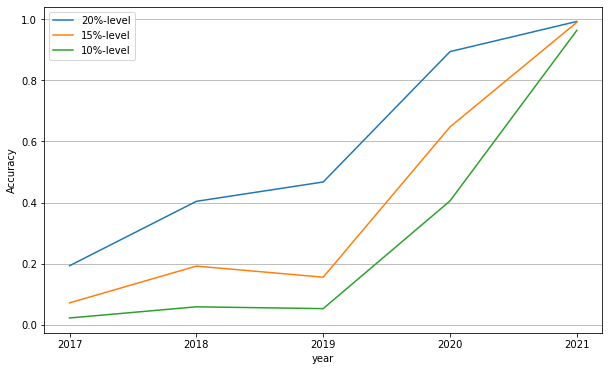

In [41]:
accuracy_data.plot(figsize = (10,6), zorder = 2)
plt.grid(axis = 'y')
plt.xticks(years)
plt.xlabel('year')
plt.ylabel('Accuracy')

plt.savefig('/Users/Mikkel/Desktop/avmaccuracies.png')

plt.show()

# Asking Price

In [184]:
avm_data = pd.read_csv("modelling_data.csv", parse_dates=['saleDate_b','valuationDate_b'])
cash = np.array(avm_data.loc[:, ['paymentCash_b']])
y = np.array(avm_data.loc[:, ['salePrice_b']])

for train_index, test_index in split.split(X, X[["itemTypeName_b"]]):
    cash_train = cash[train_index]
    cash_test = cash[test_index]
    y_train = y[train_index]
    y_test = y[test_index]

lin_cash = LinearRegression()
lin_cash.fit(cash_train, y_train.reshape(-1))
yhat = lin_cash.predict(cash_test)

In [186]:
print('MAE: ',mean_absolute_error(np.log(y_test), np.log(yhat)))
print('MAPE: ', mean_absolute_percentage_error(y_test, yhat))

MAE:  0.06263951965307483
MAPE:  0.06568399589644637


In [187]:
PercentWithinAlphaText(yhat, y_test.reshape(-1), 0.2)
PercentWithinAlphaText(yhat, y_test.reshape(-1), 0.15)
PercentWithinAlphaText(yhat, y_test.reshape(-1), 0.1)

92.83 % of predictions within  20.0 % of true value
91.4 % of predictions within  15.0 % of true value
89.25 % of predictions within  10.0 % of true value


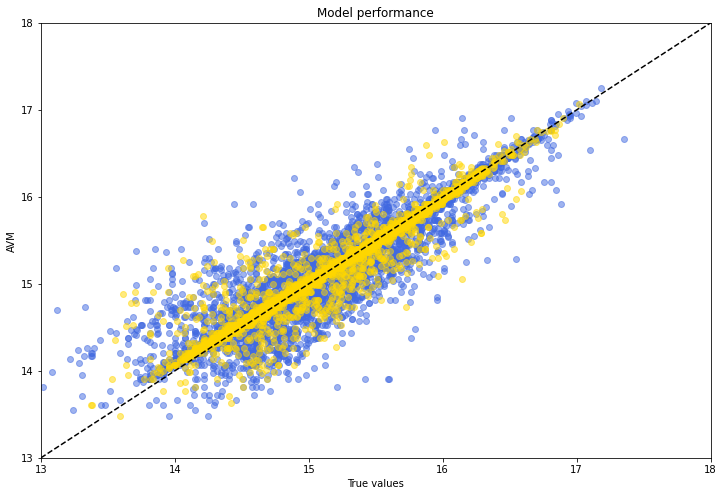

In [192]:
plt.figure(figsize = (12, 8))

plt.scatter(np.log(y_train.reshape(-1)), np.log(lin_cash.predict(cash_train)), alpha=0.5, c = 'royalblue')
plt.scatter(np.log(y_test.reshape(-1)), np.log(yhat), alpha=0.5, c = 'gold')
plt.plot([13, 18], [13, 18], ls="--", c="black")
plt.ylabel('AVM')
plt.xlabel('True values')
plt.xlim([13, 18])
plt.ylim([13, 18])

plt.title('Model performance')

plt.savefig('/Users/Mikkel/Desktop/offerprice.png')

plt.show()

In [200]:
lin_cash.coef_

array([0.94873913])